In [7]:
# Install data manipulation libraries
!pip install numpy pandas pandas_datareader

# Install visualization libraries
!pip install matplotlib seaborn plotly

# Install financial data libraries
!pip install yfinance yoptions

# Install scientific computing libraries
!pip install scipy scikit-learn statsmodels

In [8]:
# Data manipulation libraries
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Financial data libraries
import yfinance as yf

# Date and time libraries
from datetime import datetime

# Scientific computing libraries
from scipy.stats import linregress, skew, kurtosis
from scipy.optimize import minimize
from math import pi

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import yfinance as yf
from scipy.stats import kurtosis, skew

# Warnings
import warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.")

# Thoughts & Motivation
How would a quant interpret the data, to determine whether to buy share, or trade these options to hedge? For example, the Kelly fraction could be used to determine the % of a portfolio to DCA into individual shares or fractional shares. Low volatility and low probability of positive returns could mean a bearish call spread relative to % return, and high volatility and very low positive returns could be a bearish call ladder opportunity. 

1. Kelly Fraction
Interpretation: The Kelly Fraction is a measure of how much of a portfolio should be allocated to an investment to maximize growth over the long term, balancing risk and reward. A higher Kelly Fraction suggests higher confidence in positive returns.
Usage:
High Kelly Fraction: Indicates favorable market conditions. This could signal that it’s a good time to buy shares or to enter a bull put spread as a way to generate income, expecting prices to stay above a certain level.
Low or Negative Kelly Fraction: Suggests caution, as the expected returns do not justify the risk. In such cases, a bear call spread might be appropriate to profit from expected declines or stagnation without risking too much capital.

2. Volatility (Standard Deviation)
Interpretation: High volatility means large price swings, which can offer more opportunities for options traders but also comes with higher risk. Low volatility suggests a stable market, which may favor more conservative strategies.
Usage:
High Volatility: Ideal for strategies that benefit from large price movements, like bear call ladders or bull put ladders. These strategies can profit from significant movement in either direction and are more suitable when large price swings are expected.
Low Volatility: Indicates stability, which might be better for strategies like bull put spreads where limited movement is expected. Here, you are betting that the price will not drop significantly below a certain level.

3. Positive Return Percentage
Interpretation: A high positive return percentage suggests that the stock has been frequently increasing in value, signaling bullish sentiment. A low percentage indicates bearish sentiment or market corrections.
Usage:
High Positive Return Percentage: A favorable outlook for buying shares or using a bull put spread. The expectation is that the price will remain stable or rise, allowing the puts sold at a higher strike to expire worthless, yielding profit.
Low Positive Return Percentage: May indicate a bearish outlook. Strategies like a bear call spread could be used to capitalize on the likelihood of the stock not surpassing a certain price level.

4. Skewness
Interpretation: Measures the asymmetry of return distribution. Positive skewness means more small losses and occasional large gains, while negative skewness implies more small gains with rare large losses.
Usage:
Positive Skewness: Suggests potential for occasional large gains. This could align with strategies like bull put ladders where you benefit from large upward movements while having limited downside risk.
Negative Skewness: Indicates frequent small gains but vulnerability to large drops. A bear call spread or bear call ladder might be suitable to protect against significant declines.

5. Kurtosis
Interpretation: High kurtosis indicates a lot of outliers—extreme returns, both positive and negative. Low kurtosis suggests returns are closer to a normal distribution.
Usage:
High Kurtosis: High risk of large moves. Strategies like ladders (bear call or bull put) are appropriate as they can capitalize on large price movements while capping potential losses.
Low Kurtosis: Less risk of extreme moves. More stable environments where simple spread strategies might be preferable, such as a bull put spread for a bullish outlook or a bear call spread for a bearish outlook.

Example Application:

Scenario 1: If the Kelly Fraction is high, volatility is low, and the positive return percentage is high, a quant might prefer dollar-cost averaging (DCA) into shares, as this indicates a strong, stable bullish trend. Alternatively, a bull put spread could be used to generate income while maintaining limited risk.

Scenario 2: If volatility is high, Kelly Fraction is low, and skewness is negative (suggesting risk of large downward moves), a bear call ladder might be used. This strategy could profit from large downward movements while limiting potential losses.

Scenario 3: If skewness and kurtosis are both high, indicating frequent small gains but risk of large losses, a bear call spread could be a good defensive strategy, protecting against sharp declines while allowing some profit if the price remains below a certain level.

# Technical Features

[*********************100%***********************]  4 of 4 completed


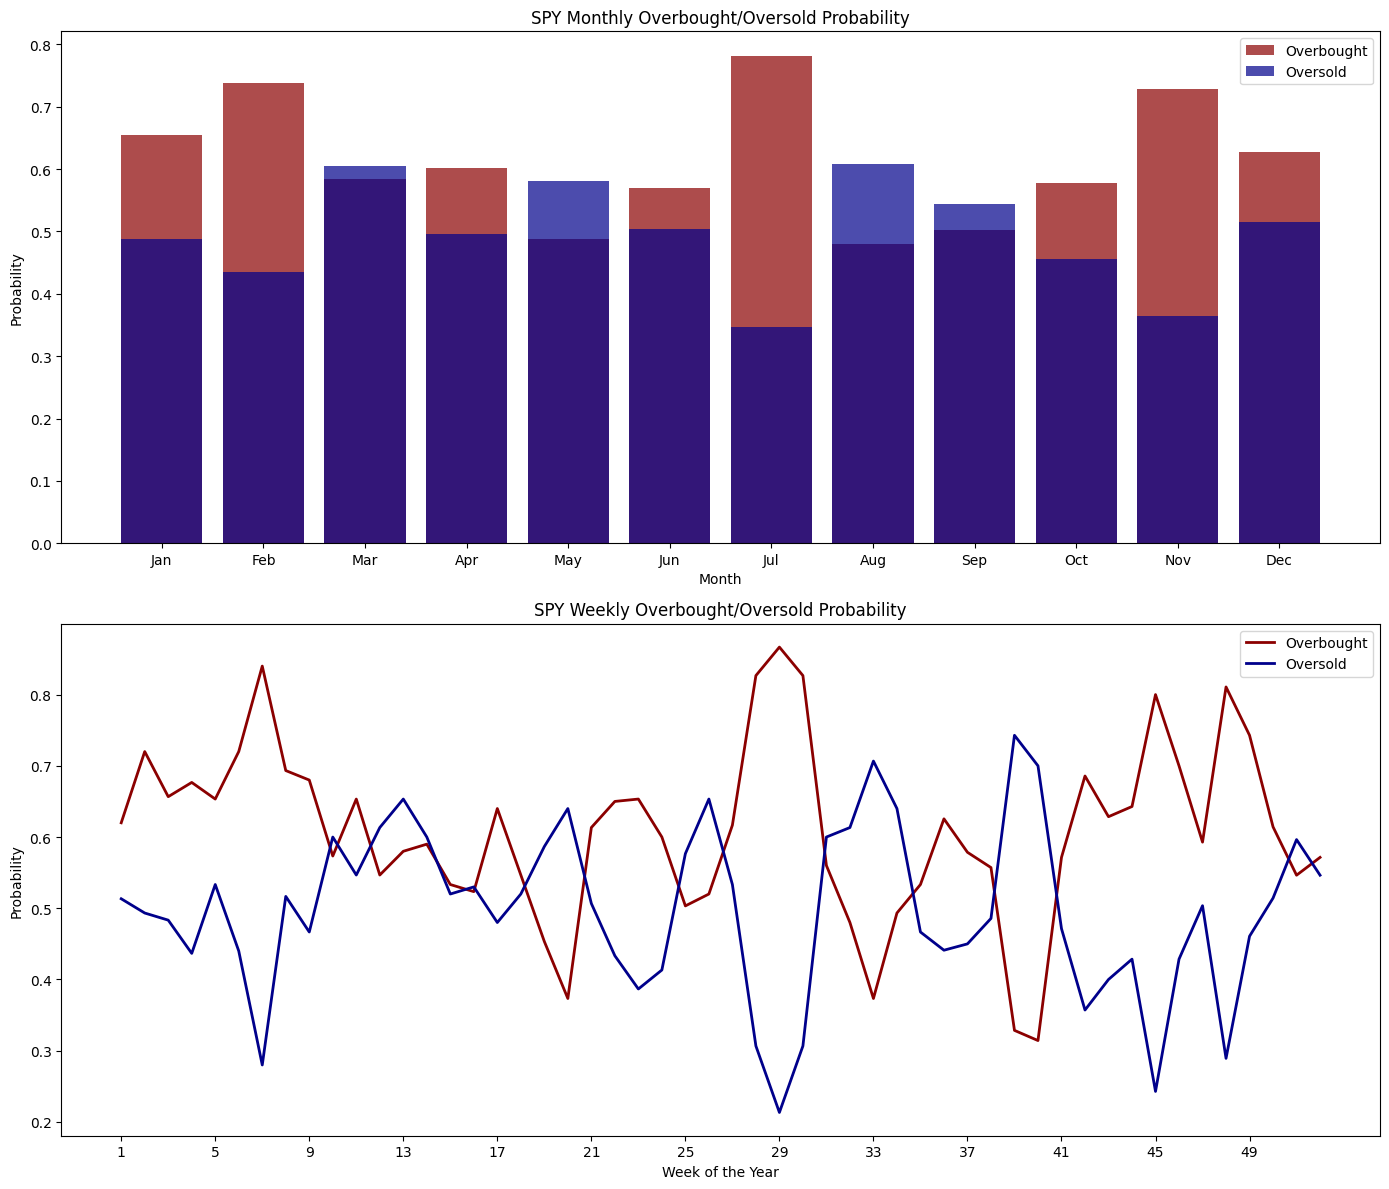

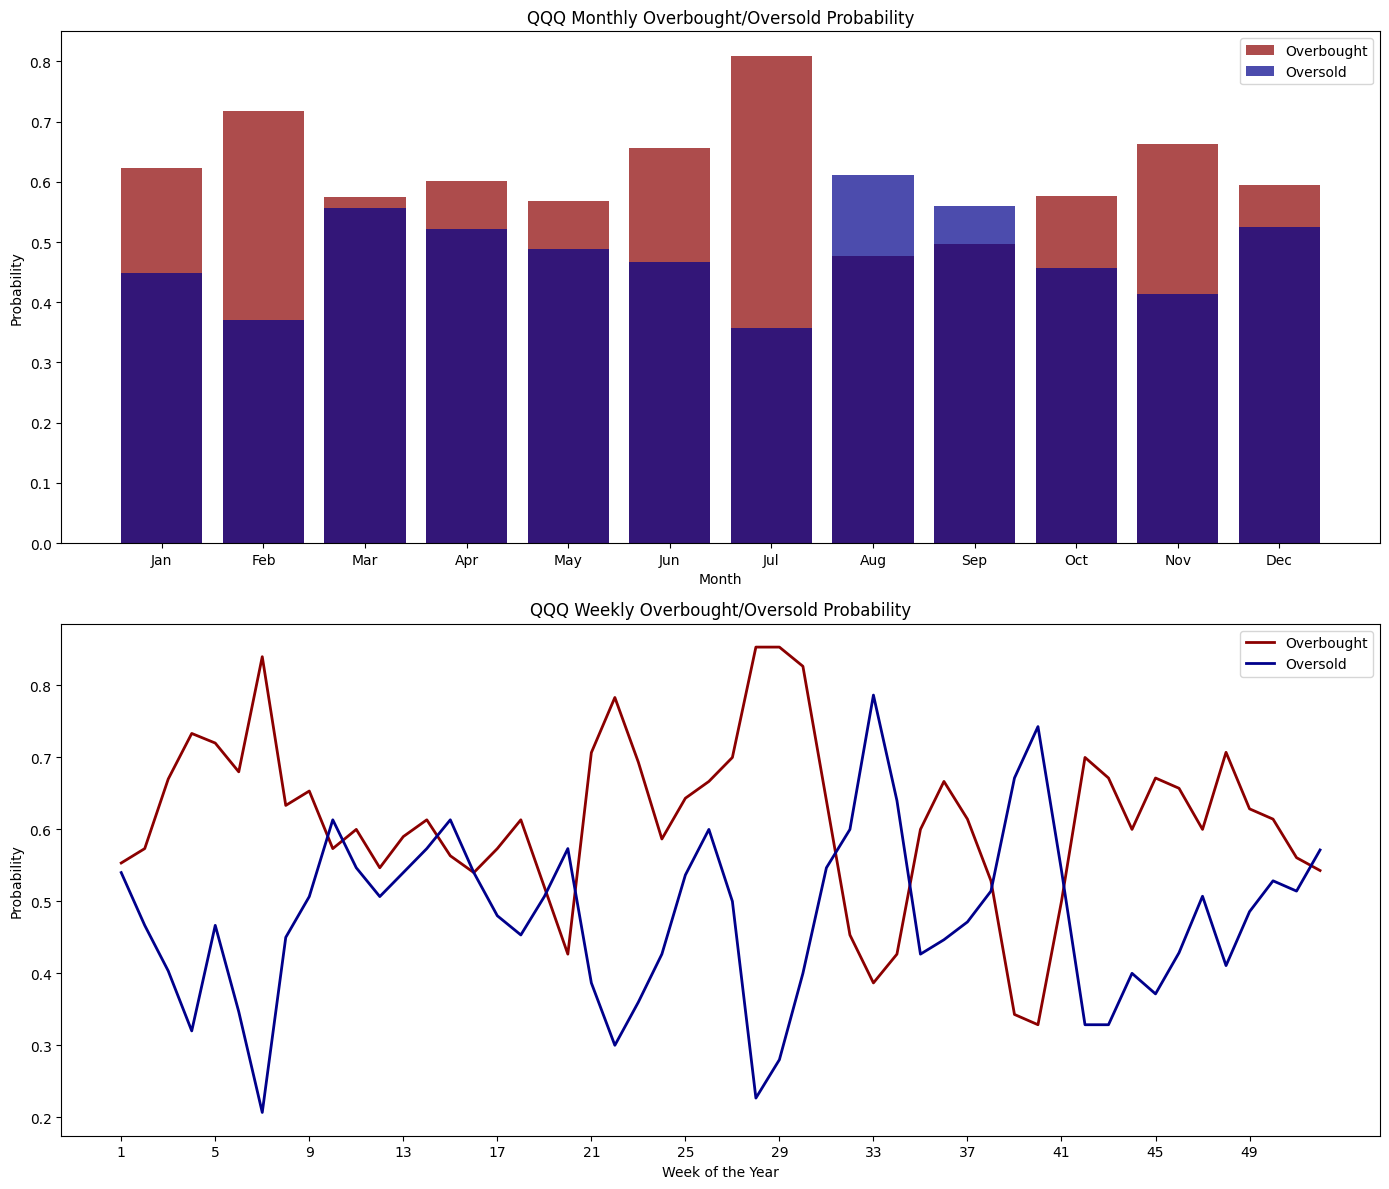

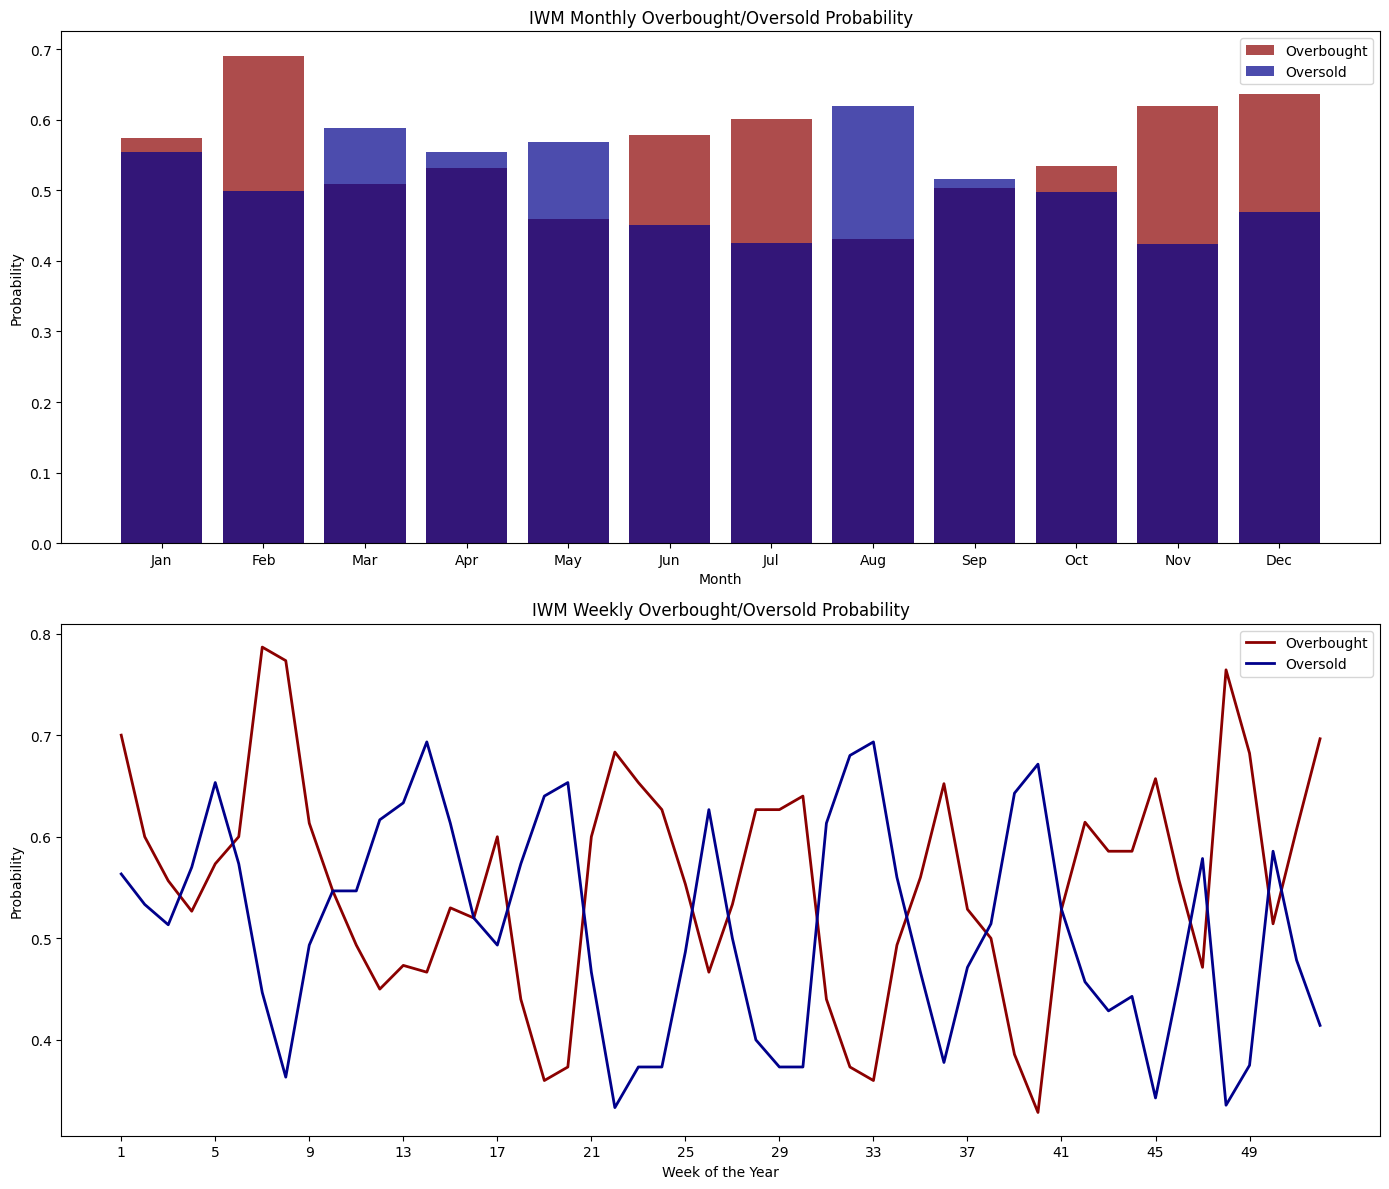

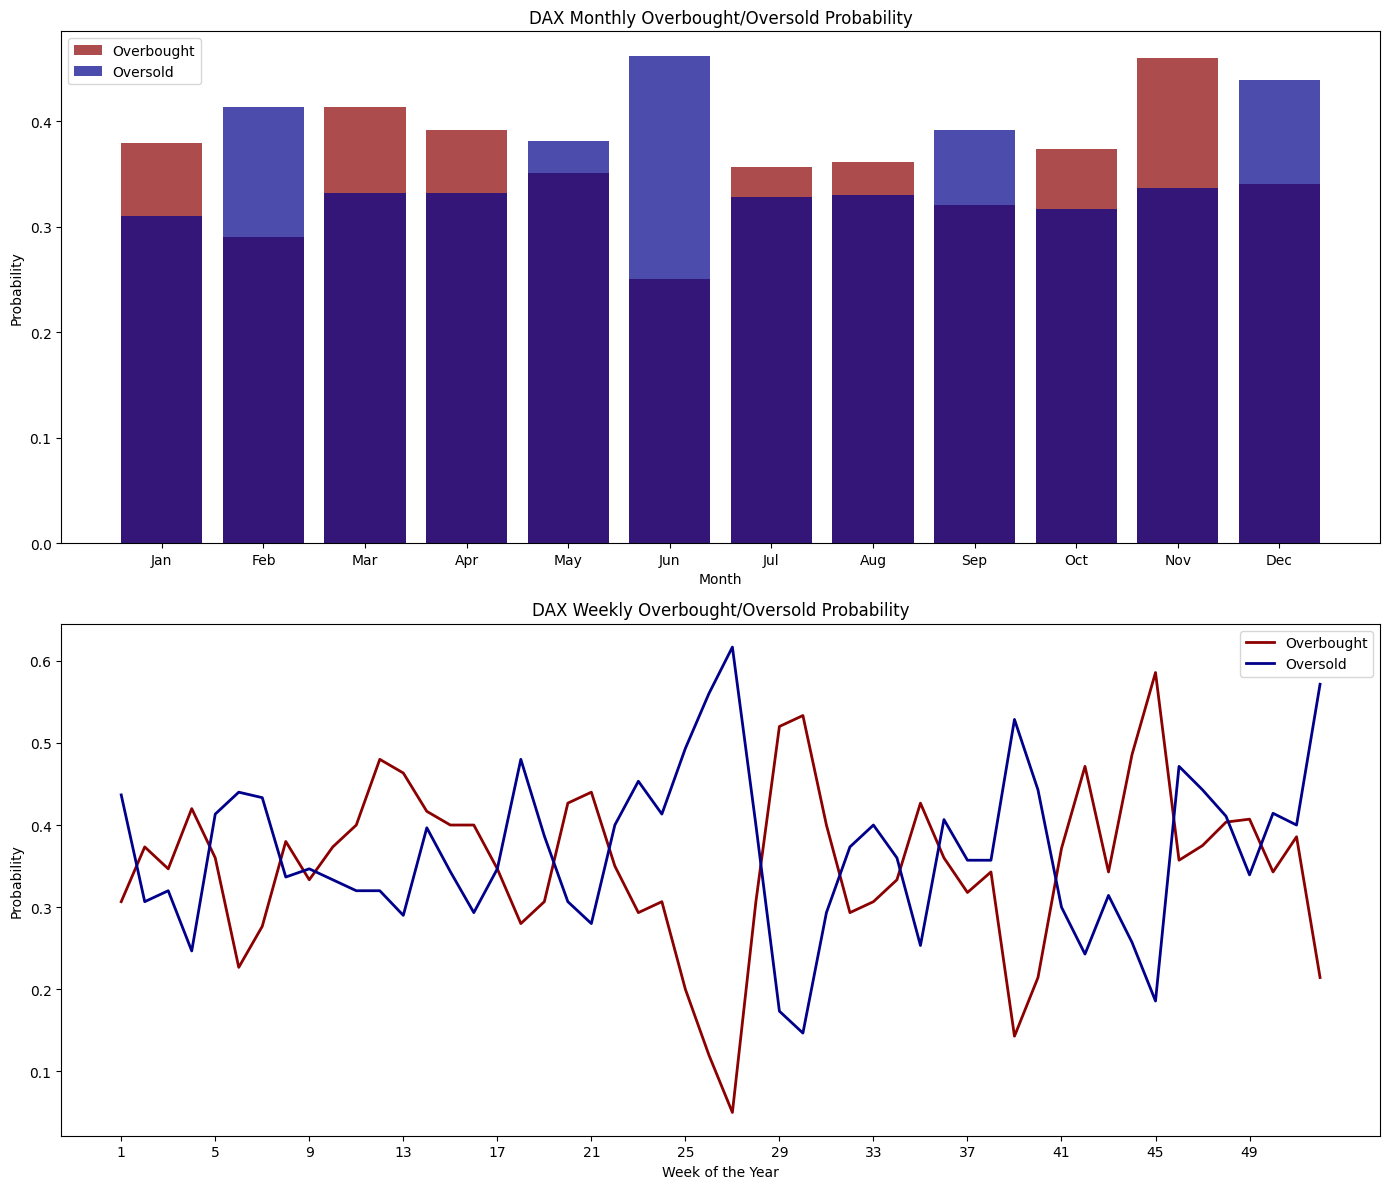

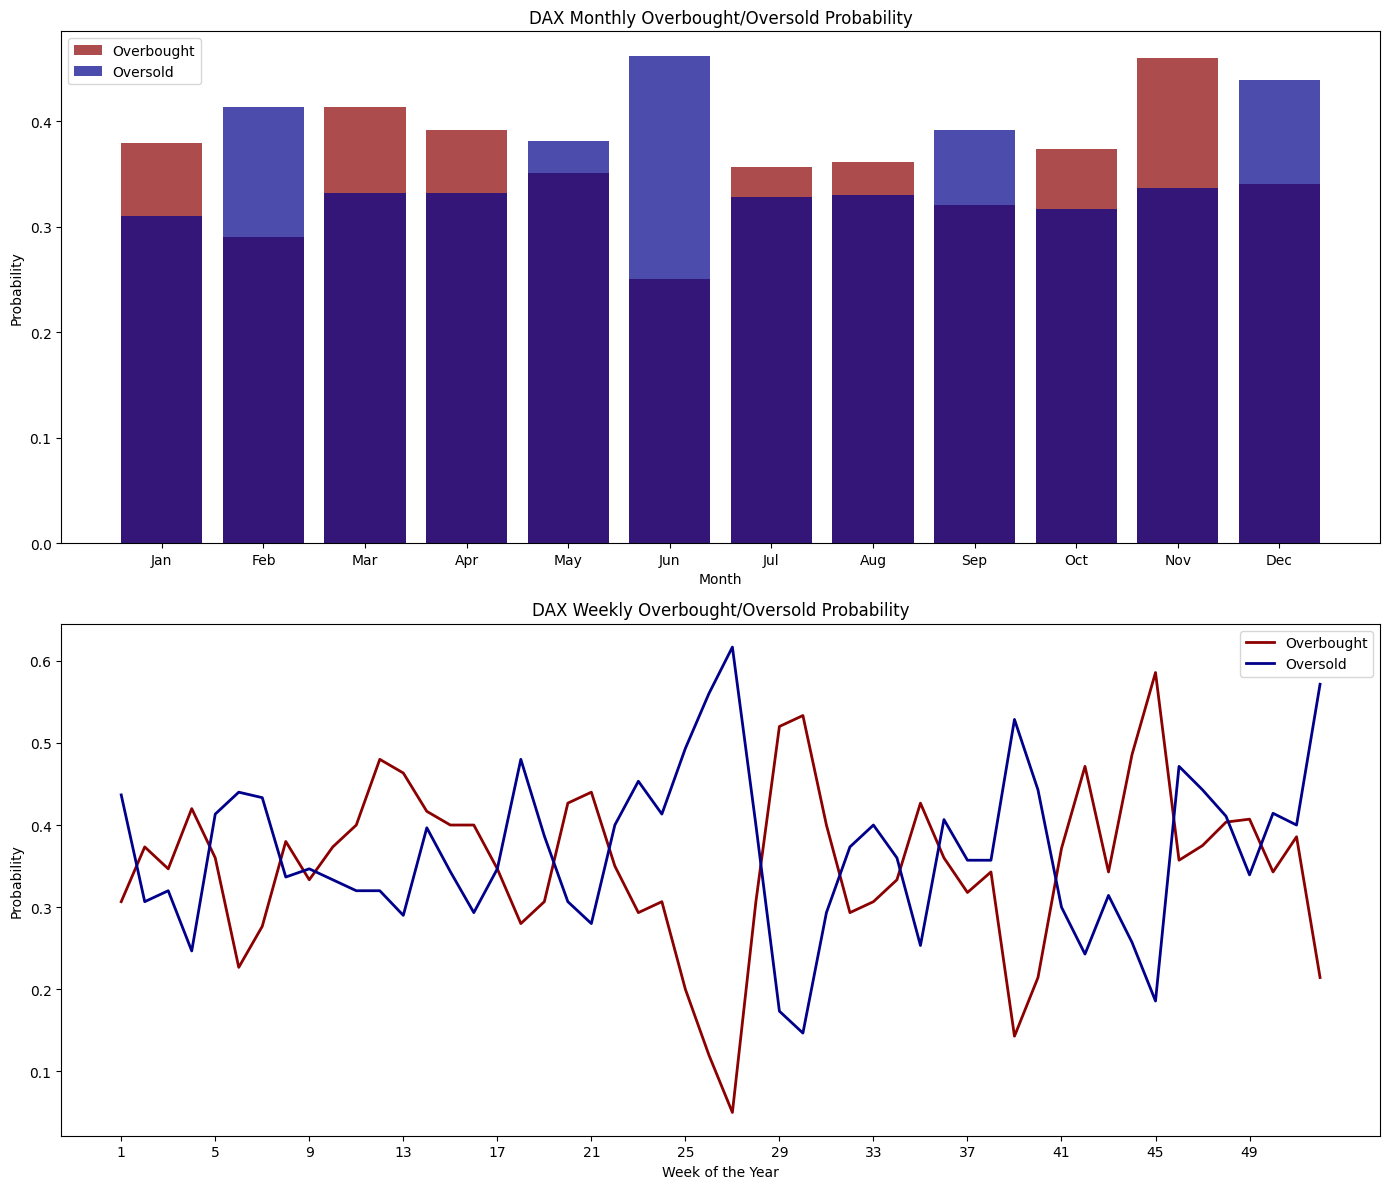

In [20]:
class TechnicalSeasonalityAnalyzer:
    def __init__(self, tickers=['SPY', 'QQQ', 'IWM', 'DAX', 'DAX'], start_date='2010-01-01', end_date=None):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')
        self.data = None

    def fetch_data(self):
        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date)

    def calculate_technical_indicators(self):
        new_columns = {}
        for ticker in self.tickers:
            close_price = self.data[('Close', ticker)]
            high_price = self.data[('High', ticker)]
            low_price = self.data[('Low', ticker)]
            volume = self.data[('Volume', ticker)]
            
            # Existing indicators
            new_columns[f'{ticker}_20D_MA'] = close_price.rolling(window=20).mean()
            new_columns[f'{ticker}_20D_STD'] = close_price.rolling(window=20).std()
            new_columns[f'{ticker}_20D_Upper'] = new_columns[f'{ticker}_20D_MA'] + 2 * new_columns[f'{ticker}_20D_STD']
            new_columns[f'{ticker}_20D_Lower'] = new_columns[f'{ticker}_20D_MA'] - 2 * new_columns[f'{ticker}_20D_STD']
            
            new_columns[f'{ticker}_52W_MA'] = close_price.rolling(window=252).mean()
            new_columns[f'{ticker}_52W_STD'] = close_price.rolling(window=252).std()
            new_columns[f'{ticker}_52W_Upper'] = new_columns[f'{ticker}_52W_MA'] + 2 * new_columns[f'{ticker}_52W_STD']
            new_columns[f'{ticker}_52W_Lower'] = new_columns[f'{ticker}_52W_MA'] - 2 * new_columns[f'{ticker}_52W_STD']
            
            delta = close_price.diff()
            gain = delta.clip(lower=0).rolling(window=14).mean()
            loss = -delta.clip(upper=0).rolling(window=14).mean()
            new_columns[f'{ticker}_RSI'] = 100 - (100 / (1 + gain / loss))

            # MACD
            exp1 = close_price.ewm(span=12, adjust=False).mean()
            exp2 = close_price.ewm(span=26, adjust=False).mean()
            new_columns[f'{ticker}_MACD'] = exp1 - exp2
            new_columns[f'{ticker}_MACD_Signal'] = new_columns[f'{ticker}_MACD'].ewm(span=9, adjust=False).mean()

            # Stochastic Oscillator
            low_14 = low_price.rolling(window=14).min()
            high_14 = high_price.rolling(window=14).max()
            new_columns[f'{ticker}_K'] = 100 * ((close_price - low_14) / (high_14 - low_14))
            new_columns[f'{ticker}_D'] = new_columns[f'{ticker}_K'].rolling(window=3).mean()

            # Trend-following indicator: ADX
            plus_dm = high_price.diff()
            minus_dm = low_price.diff()
            plus_dm[plus_dm < 0] = 0
            minus_dm[minus_dm > 0] = 0
            tr1 = pd.DataFrame(high_price - low_price)
            tr2 = pd.DataFrame(abs(high_price - close_price.shift(1)))
            tr3 = pd.DataFrame(abs(low_price - close_price.shift(1)))
            frames = [tr1, tr2, tr3]
            tr = pd.concat(frames, axis=1, join='inner').max(axis=1)
            atr = tr.rolling(14).mean()
            plus_di = 100 * (plus_dm.ewm(alpha=1/14).mean() / atr)
            minus_di = abs(100 * (minus_dm.ewm(alpha=1/14).mean() / atr))
            dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
            new_columns[f'{ticker}_ADX'] = dx.ewm(alpha=1/14).mean()

            # Volume indicator: On-Balance Volume (OBV)
            new_columns[f'{ticker}_OBV'] = (volume * (~close_price.diff().le(0) * 2 - 1)).cumsum()

            # Momentum indicator: Rate of Change (ROC)
            new_columns[f'{ticker}_ROC'] = ((close_price - close_price.shift(10)) / close_price.shift(10)) * 100

        # Join all new columns at once
        self.data = pd.concat([self.data, pd.DataFrame(new_columns)], axis=1)

    def analyze_overbought_oversold(self):
        results = {}
        for ticker in self.tickers:
            overbought = (
                (self.data[f'{ticker}_RSI'] > 70) |
                (self.data[('Close', ticker)] > self.data[f'{ticker}_20D_Upper']) |
                (self.data[('Close', ticker)] > self.data[f'{ticker}_52W_Upper']) |
                (self.data[f'{ticker}_K'] > 80) |
                (self.data[f'{ticker}_D'] > 80) |
                (self.data[f'{ticker}_MACD'] > self.data[f'{ticker}_MACD_Signal']) |
                (self.data[f'{ticker}_ROC'] > 10)
            )
            oversold = (
                (self.data[f'{ticker}_RSI'] < 30) |
                (self.data[('Close', ticker)] < self.data[f'{ticker}_20D_Lower']) |
                (self.data[('Close', ticker)] < self.data[f'{ticker}_52W_Lower']) |
                (self.data[f'{ticker}_K'] < 20) |
                (self.data[f'{ticker}_D'] < 20) |
                (self.data[f'{ticker}_MACD'] < self.data[f'{ticker}_MACD_Signal']) |
                (self.data[f'{ticker}_ROC'] < -10)
            )
            
            monthly_overbought = overbought.resample('M').mean()
            monthly_oversold = oversold.resample('M').mean()
            weekly_overbought = overbought.resample('W').mean()
            weekly_oversold = oversold.resample('W').mean()
            
            results[ticker] = {
                'monthly_overbought': monthly_overbought,
                'monthly_oversold': monthly_oversold,
                'weekly_overbought': weekly_overbought,
                'weekly_oversold': weekly_oversold
            }
        
        return results

    def analyze_indicators(self):
        results = {}
        for ticker in self.tickers:
            results[ticker] = {
                'RSI': self.data[f'{ticker}_RSI'],
                'MACD': self.data[f'{ticker}_MACD'],
                'MACD_Signal': self.data[f'{ticker}_MACD_Signal'],
                'K': self.data[f'{ticker}_K'],
                'D': self.data[f'{ticker}_D'],
                'ADX': self.data[f'{ticker}_ADX'],
                'OBV': self.data[f'{ticker}_OBV'],
                'ROC': self.data[f'{ticker}_ROC'],
                '20D_Upper': self.data[f'{ticker}_20D_Upper'],
                '20D_Lower': self.data[f'{ticker}_20D_Lower'],
                '52W_Upper': self.data[f'{ticker}_52W_Upper'],
                '52W_Lower': self.data[f'{ticker}_52W_Lower'],
                'Close': self.data[('Close', ticker)]
            }
        return results

    def plot_overbought_oversold(self, overbought_oversold_results):
        for ticker in self.tickers:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
            
            # Monthly plot
            monthly_data = overbought_oversold_results[ticker]['monthly_overbought'].groupby(overbought_oversold_results[ticker]['monthly_overbought'].index.month).mean()
            monthly_data = monthly_data.reindex(range(1, 13))
            ax1.bar(monthly_data.index, monthly_data.values, alpha=0.7, color='#8B0000', label='Overbought')
            
            monthly_data = overbought_oversold_results[ticker]['monthly_oversold'].groupby(overbought_oversold_results[ticker]['monthly_oversold'].index.month).mean()
            monthly_data = monthly_data.reindex(range(1, 13))
            ax1.bar(monthly_data.index, monthly_data.values, alpha=0.7, color='#00008B', label='Oversold')
            
            ax1.set_title(f'{ticker} Monthly Overbought/Oversold Probability')
            ax1.set_xlabel('Month')
            ax1.set_ylabel('Probability')
            ax1.set_xticks(range(1, 13))
            ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            ax1.legend()
            
            # Weekly plot
            weekly_data = overbought_oversold_results[ticker]['weekly_overbought'].groupby(overbought_oversold_results[ticker]['weekly_overbought'].index.isocalendar().week).mean()
            weekly_data = weekly_data.reindex(range(1, 53))
            ax2.plot(weekly_data.index, weekly_data.values, color='#8B0000', linewidth=2, label='Overbought')
            
            weekly_data = overbought_oversold_results[ticker]['weekly_oversold'].groupby(overbought_oversold_results[ticker]['weekly_oversold'].index.isocalendar().week).mean()
            weekly_data = weekly_data.reindex(range(1, 53))
            ax2.plot(weekly_data.index, weekly_data.values, color='#00008B', linewidth=2, label='Oversold')
            
            ax2.set_title(f'{ticker} Weekly Overbought/Oversold Probability')
            ax2.set_xlabel('Week of the Year')
            ax2.set_ylabel('Probability')
            ax2.set_xticks(range(1, 53, 4))
            ax2.legend()
            
            plt.tight_layout()
            plt.show()

    def run_analysis(self):
        self.fetch_data()
        self.calculate_technical_indicators()
        overbought_oversold_results = self.analyze_overbought_oversold()
        indicator_results = self.analyze_indicators()
        self.plot_overbought_oversold(overbought_oversold_results)

# Example usage
analyzer = TechnicalSeasonalityAnalyzer()
analyzer.run_analysis()



Strategy: The combination of lower Kelly Ratio, lower positive return percentage, negative skewness, and positive kurtosis suggests that bearish strategies are appropriate. A Bear Call Spread would be ideal to capitalize on limited upside while protecting against potential declines. For higher volatility within these months, a Bear Call Ladder could be considered, especially if kurtosis and skewness values indicate the potential for large price swings.

Bullish Months (January, April, November, December):

Kelly Ratio: 0.0757, Kelly Fraction: 0.0378 – Higher, suggesting more confidence in positive returns.
Volatility (Std_Dev): 0.0095 – Moderate volatility, indicating some movement but within a bullish trend.
Positive Return Percentage: 54.69% – Higher, consistent with bullish sentiment.
Skewness: 0.1009 – Positive skewness implies more frequent small losses and fewer large gains.
Kurtosis: -0.0447 – Negative kurtosis suggests less likelihood of extreme movements.
Strategy: Higher Kelly ratios, positive return percentage, and moderate volatility suggest bullish strategies. A Bull Put Spread is appropriate, benefiting from a stable or rising market. If there are expectations of larger upward movements (based on specific market events or economic data), a Bull Put Ladder can capture larger gains with controlled risk.

Neutral or Mixed Months (Remaining Months):

Kelly Ratio: 0.0751, Kelly Fraction: 0.0375 – Similar to bullish months but requires more careful monitoring.
Volatility (Std_Dev): 0.0099 – Highest among categories, indicating unpredictability.
Positive Return Percentage: 54.66% – Comparable to bullish months, suggesting mixed sentiment.
Skewness: -0.1997 – Slightly negative, indicating a tendency towards losses.
Kurtosis: 0.0694 – Slightly positive, indicating some risk of extreme movements.
Strategy: In neutral or mixed months, where volatility is highest and sentiment is unclear, non-directional strategies such as an Iron Condor are appropriate. These strategies profit from limited price movement and can be adjusted if the market starts to trend.

Conclusion
By applying quantitative metrics to historical data, we can align option trading strategies with expected market conditions:

Bearish Months: Favor bear call spreads or ladders, expecting limited upside.
Bullish Months: Favor bull put spreads or ladders, expecting price stability or rise.
Neutral Months: Favor non-directional strategies like iron condors, expecting limited movement.


# Display Monthly Seasonality

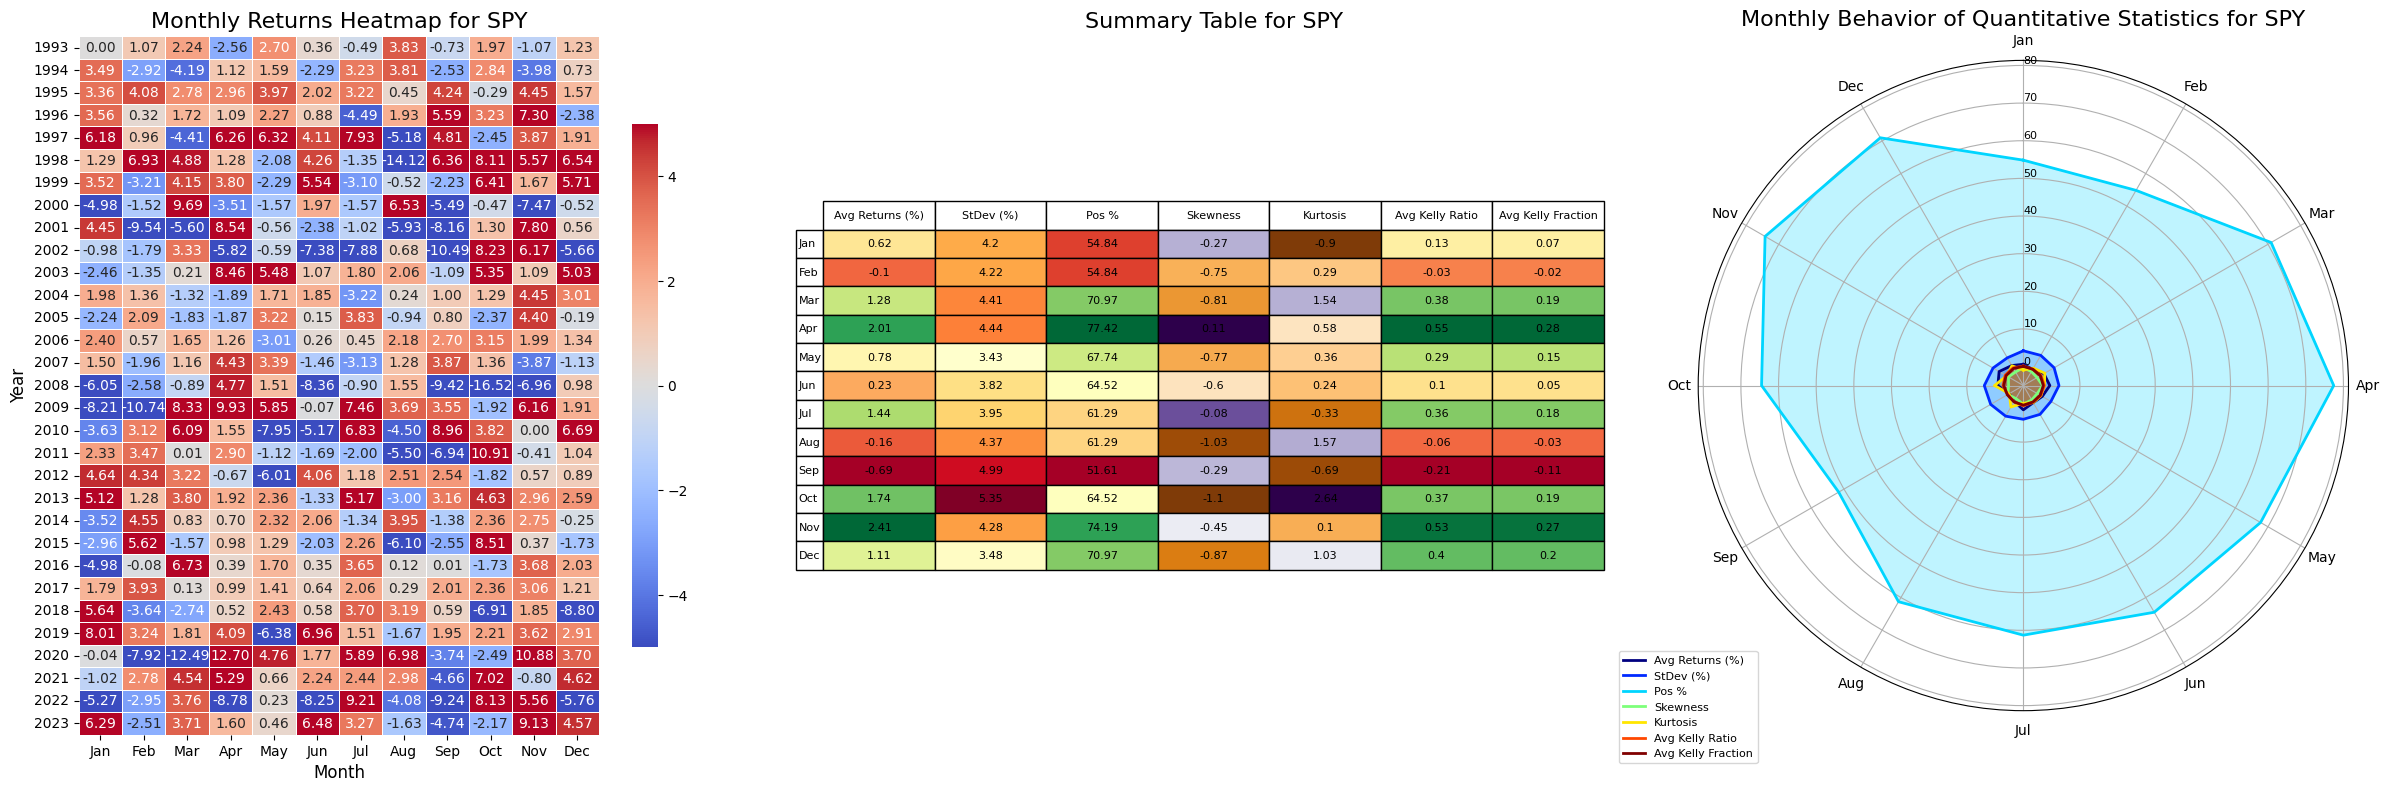

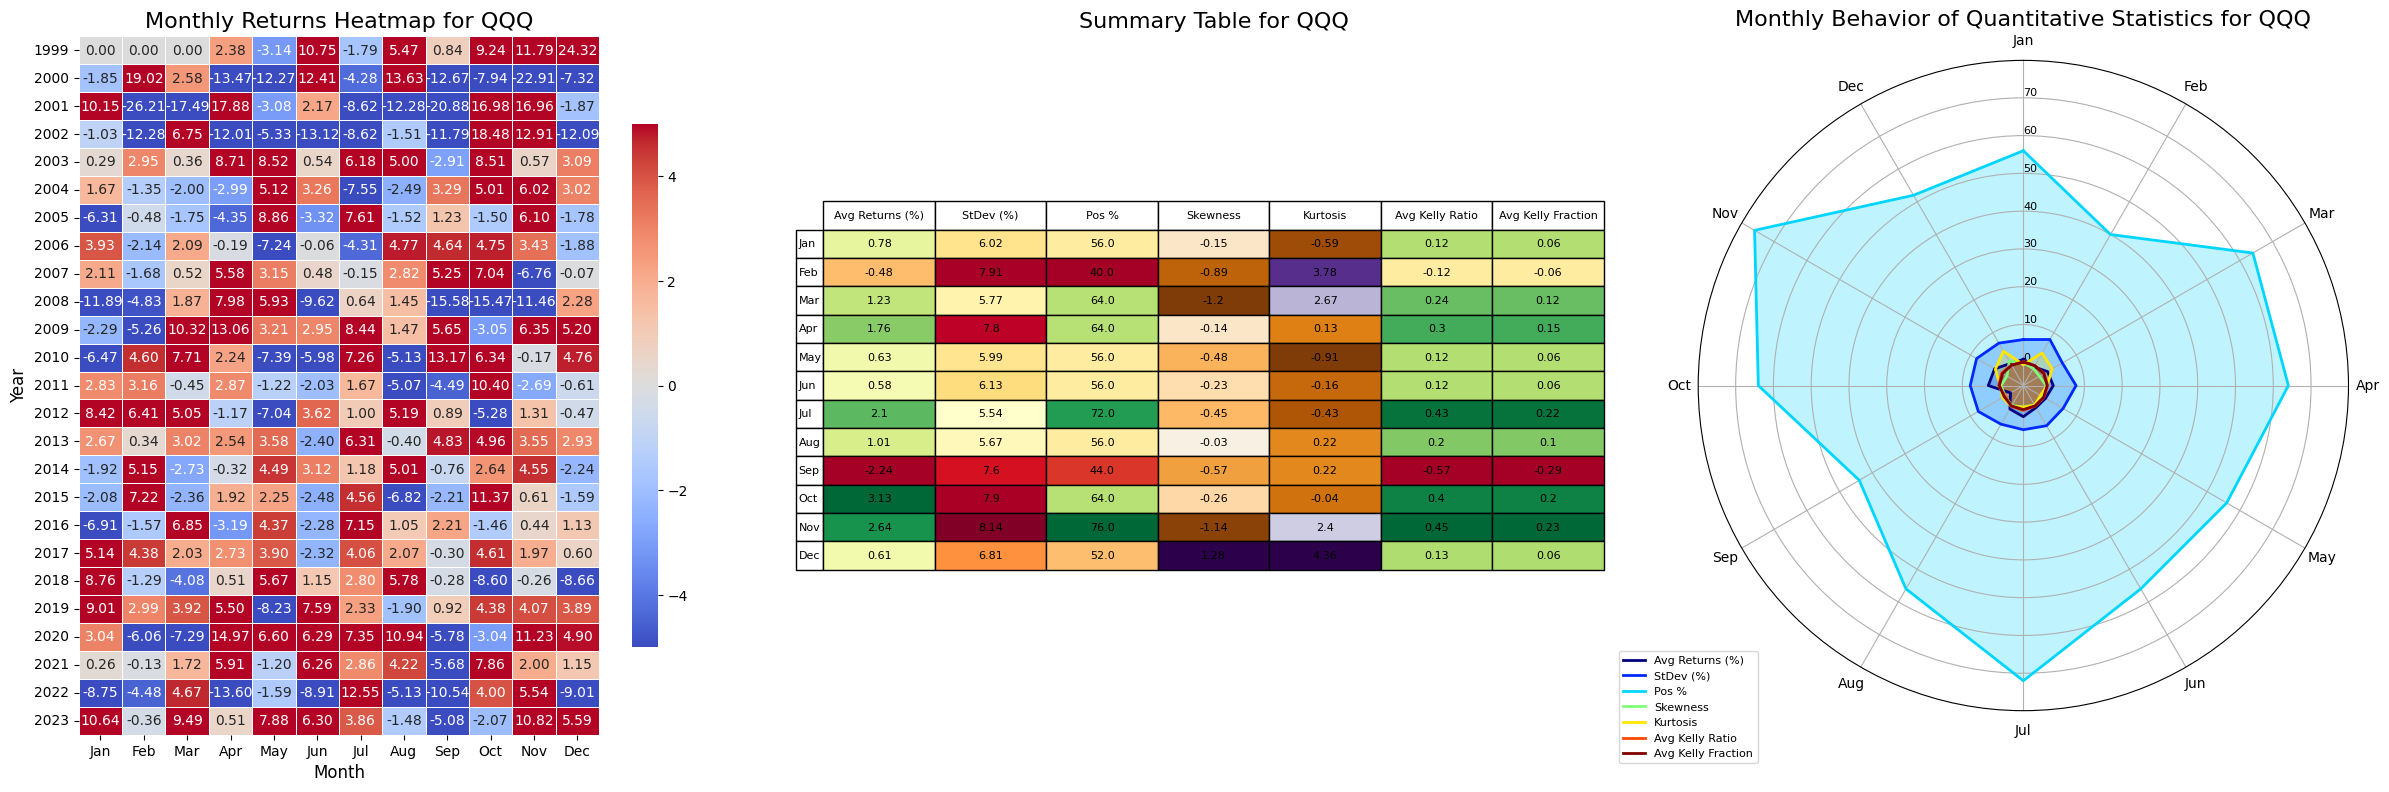

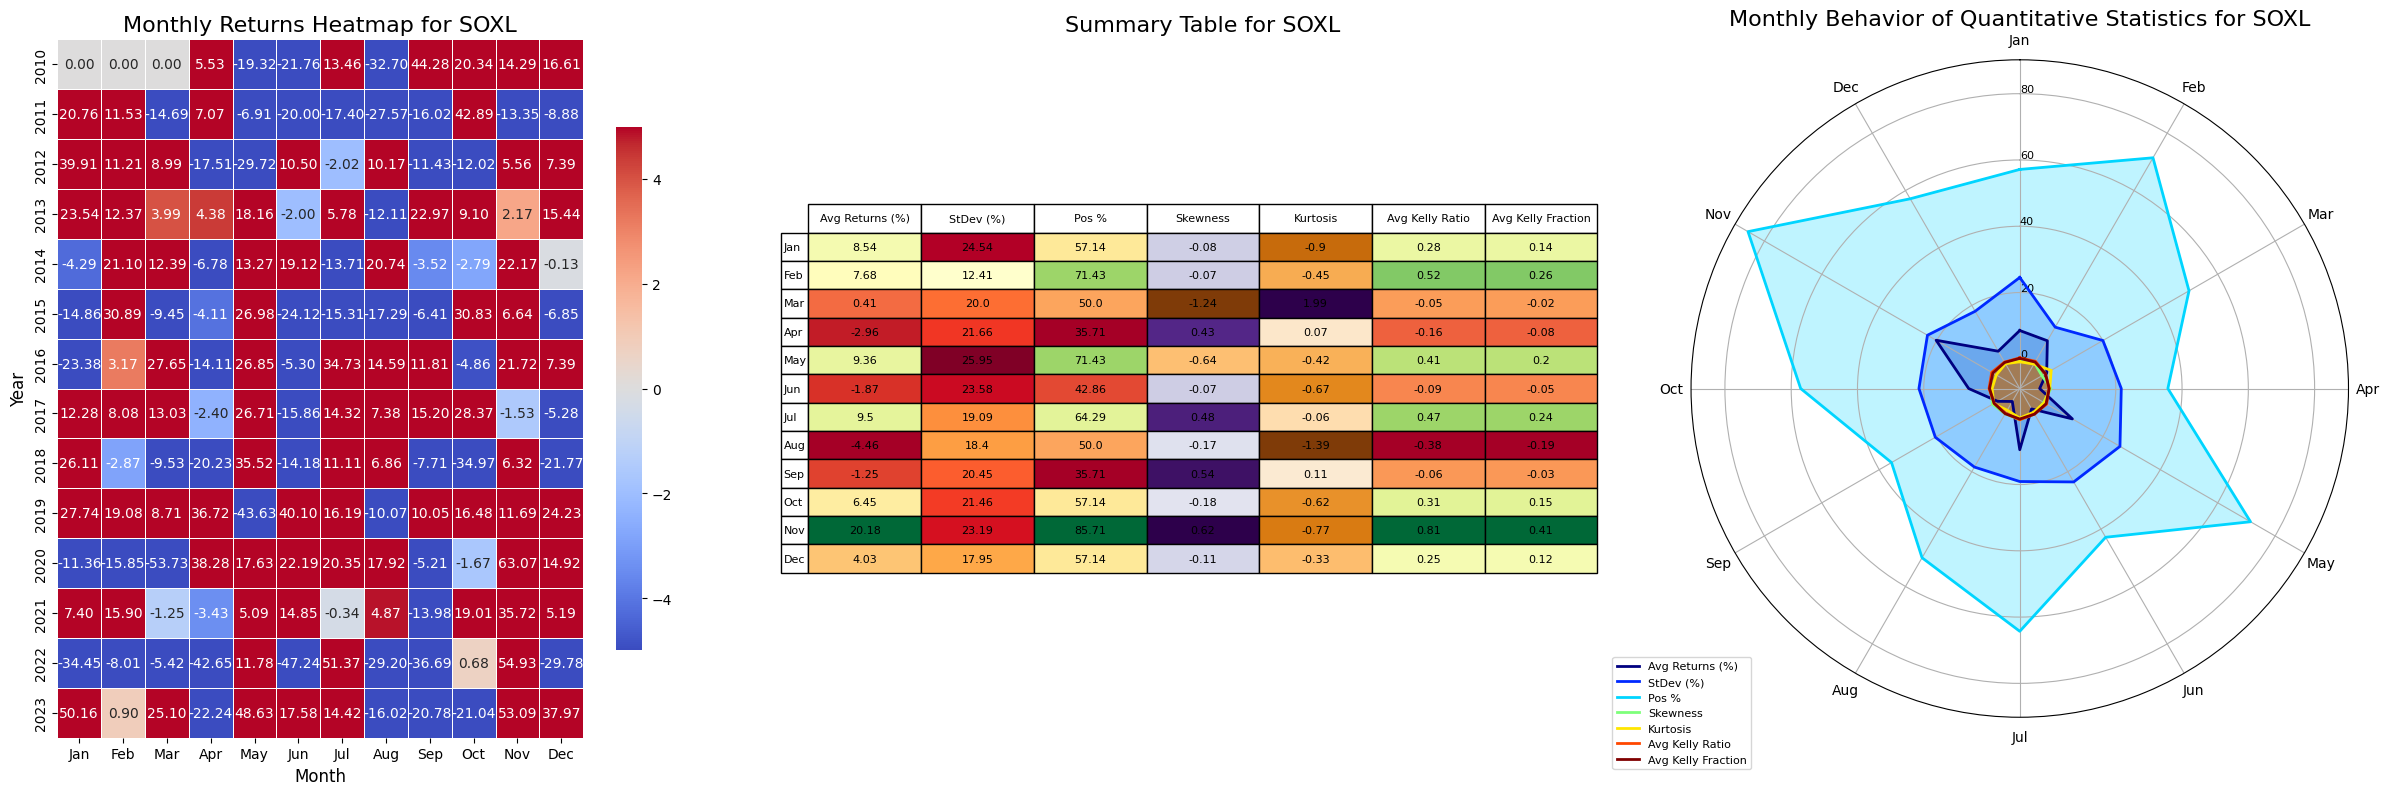

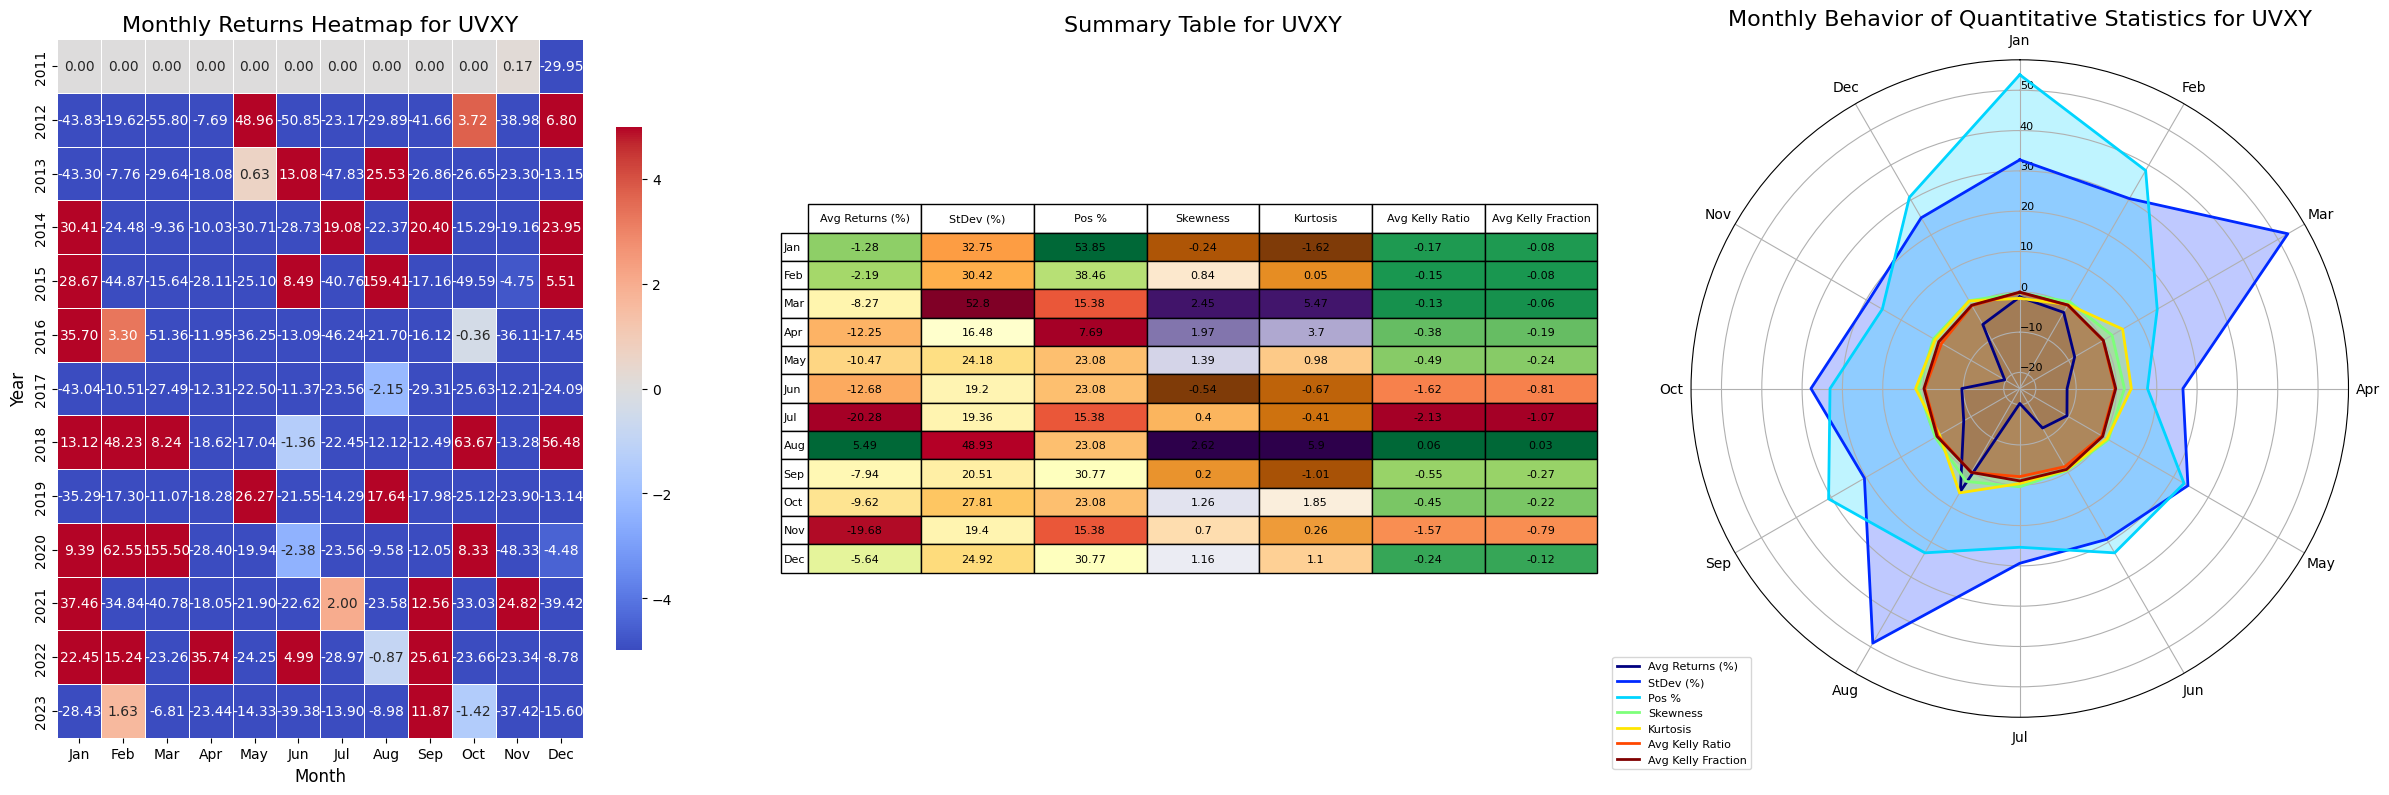

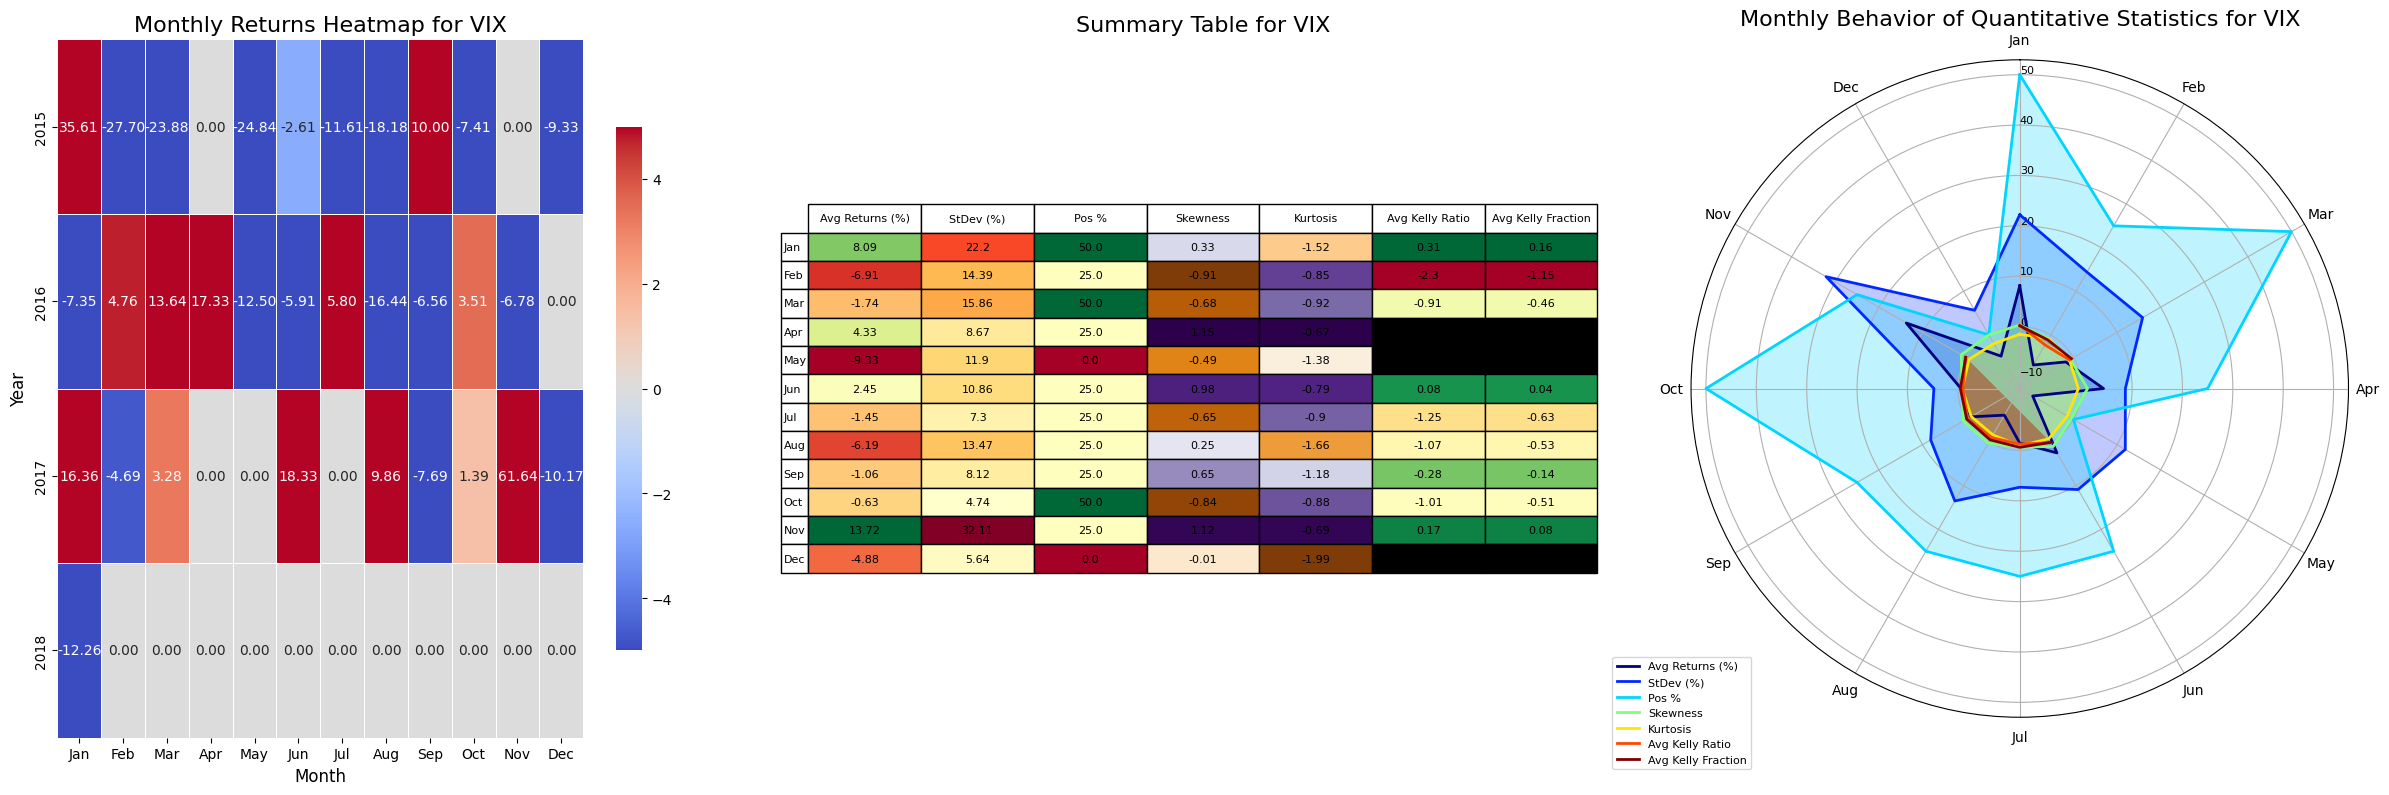

In [19]:
class MonthlySeasonalityAnalyzer:
    def __init__(self, ticker='SPY', start='1990-01-01', end='2023-12-31'):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.data = None
        self.pivot_table = None
        self.summary_table = None

    def fetch_and_process_data(self):
        # Fetch data
        self.data = yf.download(self.ticker, start=self.start, end=self.end, progress=False)['Adj Close']
        
        # Calculate monthly returns
        monthly_data = self.data.resample('M').ffill()
        monthly_returns = monthly_data.pct_change().dropna() * 100  # Convert to percentage
        
        # Organize returns into a pivot table
        monthly_returns = monthly_returns.to_frame(name='Adj Close')
        monthly_returns['Year'] = monthly_returns.index.to_period('M').year
        monthly_returns['Month'] = monthly_returns.index.to_period('M').month
        monthly_returns['Month'] = monthly_returns['Month'].apply(lambda x: pd.Timestamp(2023, x, 1).strftime('%b'))  # Using strftime to get month abbreviation
        self.pivot_table = monthly_returns.pivot_table(index='Year', columns='Month', values='Adj Close', aggfunc='mean')
        self.pivot_table = self.pivot_table.fillna(0)  # Replace NaN with 0 for months without data

    def calculate_metrics(self):
        # Ensure columns are in the correct order
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        self.pivot_table = self.pivot_table[months]

        # Function to calculate Kelly ratio and fraction
        def calculate_kelly_ratio(returns):
            win_prob = np.mean(returns > 0)
            loss_prob = 1 - win_prob
            win_return = np.mean(returns[returns > 0])
            loss_return = abs(np.mean(returns[returns < 0]))
            kelly_ratio = win_prob - (loss_prob / (win_return / loss_return))
            return kelly_ratio, kelly_ratio / 2  # Kelly fraction as half of Kelly ratio

        # Calculate metrics
        avg_returns = self.pivot_table.mean()
        std_dev = self.pivot_table.std()
        pos_perc = (self.pivot_table > 0).mean() * 100
        skewness = self.pivot_table.apply(lambda x: skew(x.dropna()), axis=0)
        kurt = self.pivot_table.apply(lambda x: kurtosis(x.dropna()), axis=0)

        # Kelly ratio and fraction
        kelly_ratios = self.pivot_table.apply(lambda x: calculate_kelly_ratio(x.dropna()), axis=0)
        avg_kelly_ratio = kelly_ratios.apply(lambda x: x[0])
        avg_kelly_fraction = kelly_ratios.apply(lambda x: x[1])

        # Create summary table
        self.summary_table = pd.DataFrame({
            'Avg Returns (%)': avg_returns,
            'StDev (%)': std_dev,
            'Pos %': pos_perc,
            'Skewness': skewness,
            'Kurtosis': kurt,
            'Avg Kelly Ratio': avg_kelly_ratio,
            'Avg Kelly Fraction': avg_kelly_fraction
        })

    def visualize_data(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
        
        # Heatmap
        sns.heatmap(self.pivot_table, annot=True, fmt=".2f", cmap="coolwarm", vmin=-5, vmax=5, center=0, linewidths=.5, cbar_kws={"shrink": .75}, ax=ax1)
        ax1.set_title(f'Monthly Returns Heatmap for {self.ticker}', fontsize=16)
        ax1.set_xlabel('Month', fontsize=12)
        ax1.set_ylabel('Year', fontsize=12)
        ax1.tick_params(axis='both', which='major', labelsize=10)

        # Summary table
        ax2.axis('tight')
        ax2.axis('off')
        
        def color_scale(val, cmap, vmin, vmax):
            norm = plt.Normalize(vmin, vmax)
            return plt.cm.colors.rgb2hex(cmap(norm(val)))
        
        cell_colors = []
        for col in self.summary_table.columns:
            if col in ['Avg Returns (%)', 'Pos %', 'Avg Kelly Ratio', 'Avg Kelly Fraction']:
                colors = [color_scale(x, plt.cm.RdYlGn, self.summary_table[col].min(), self.summary_table[col].max()) for x in self.summary_table[col]]
            elif col == 'StDev (%)':
                colors = [color_scale(x, plt.cm.YlOrRd, self.summary_table[col].min(), self.summary_table[col].max()) for x in self.summary_table[col]]
            else:  # Skewness and Kurtosis
                colors = [color_scale(x, plt.cm.PuOr, self.summary_table[col].min(), self.summary_table[col].max()) for x in self.summary_table[col]]
            cell_colors.append(colors)
        
        table = ax2.table(cellText=self.summary_table.values.round(2), 
                         colLabels=self.summary_table.columns, 
                         rowLabels=self.summary_table.index, 
                         cellLoc='center', 
                         loc='center',
                         cellColours=list(map(list, zip(*cell_colors))))
        
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.2, 1.5)
        
        ax2.set_title(f'Summary Table for {self.ticker}', fontsize=16)

        # Radar chart
        categories = list(self.summary_table.index)
        N = len(categories)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        if ax3:
            ax3.remove()
        ax3 = plt.subplot(133, polar=True)

        colors = plt.cm.jet(np.linspace(0, 1, 7))
        metrics = ['Avg Returns (%)', 'StDev (%)', 'Pos %', 'Skewness', 'Kurtosis', 'Avg Kelly Ratio', 'Avg Kelly Fraction']
        for i, column in enumerate(metrics):
            values = self.summary_table[column].values.flatten().tolist()
            values += values[:1]
            ax3.plot(angles, values, linewidth=2, linestyle='solid', label=column, color=colors[i])
            ax3.fill(angles, values, alpha=0.25, color=colors[i])

        ax3.set_theta_offset(pi / 2)
        ax3.set_theta_direction(-1)
        plt.xticks(angles[:-1], categories, fontsize=10)
        ax3.set_rlabel_position(0)
        plt.yticks(fontsize=8)
        ax3.set_title(f'Monthly Behavior of Quantitative Statistics for {self.ticker}', fontsize=16)
        ax3.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=8)

        plt.tight_layout()
        plt.show()

# Example usage:
tickers = ['SPY', 'QQQ', 'SOXL', 'UVXY', 'VIX']
for ticker in tickers:
    analyzer = MonthlySeasonalityAnalyzer(ticker=ticker)
    analyzer.fetch_and_process_data()
    analyzer.calculate_metrics()
    analyzer.visualize_data()


# 52 Week Seasonality with Kelly Method

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


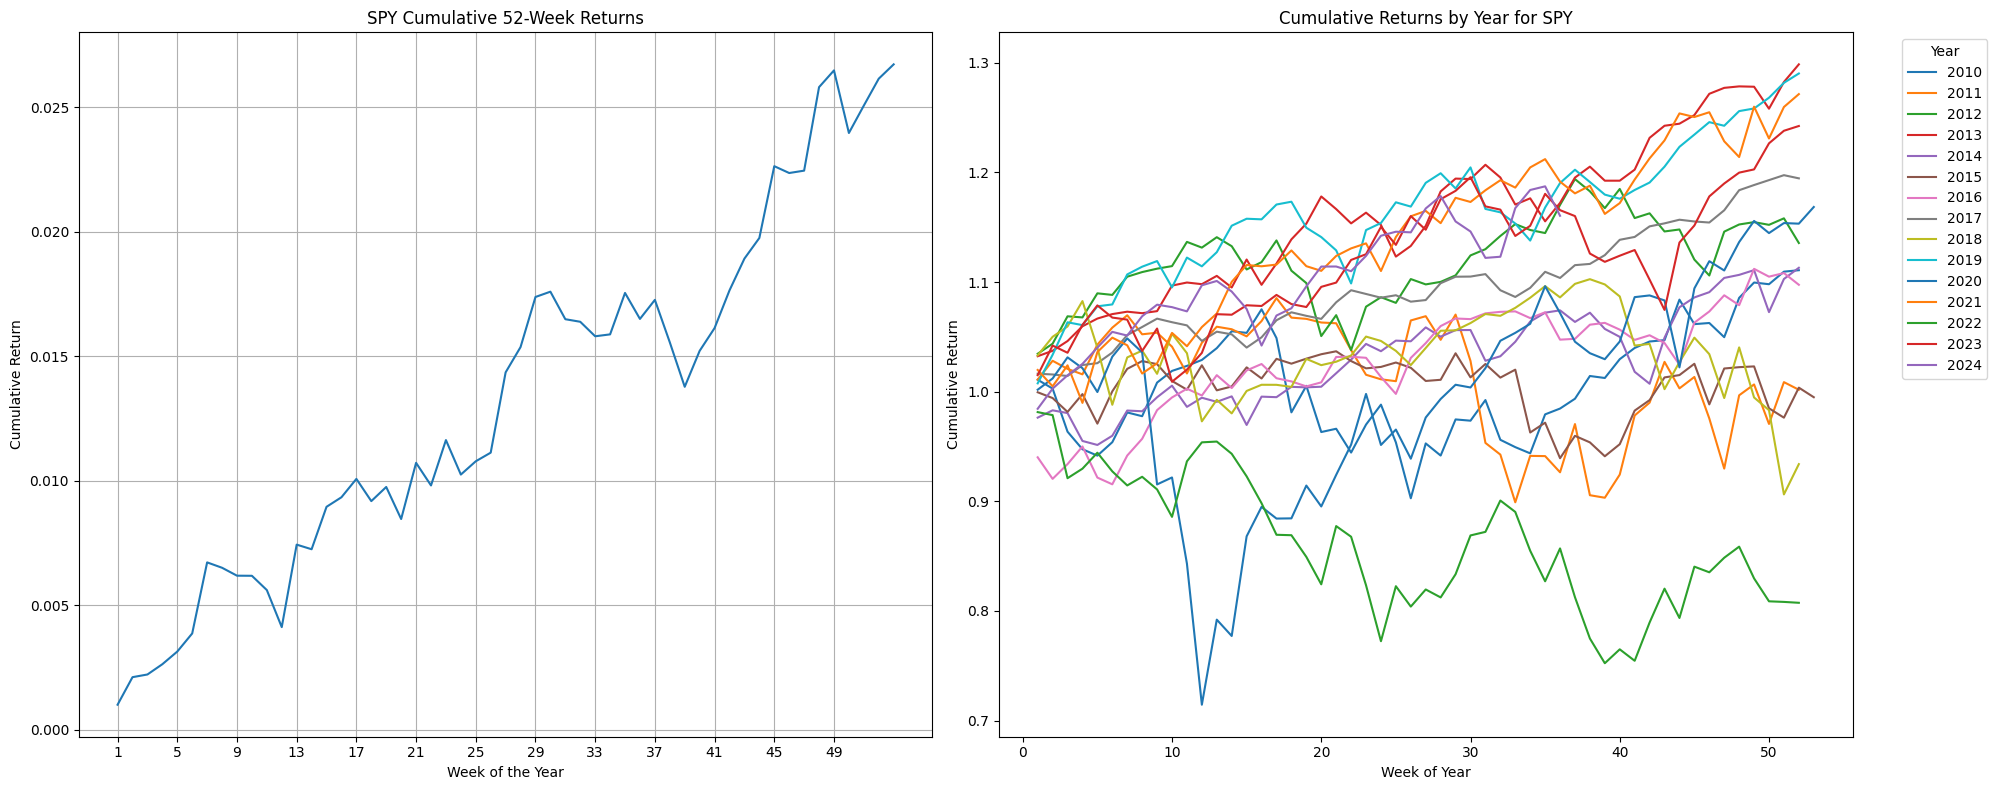

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


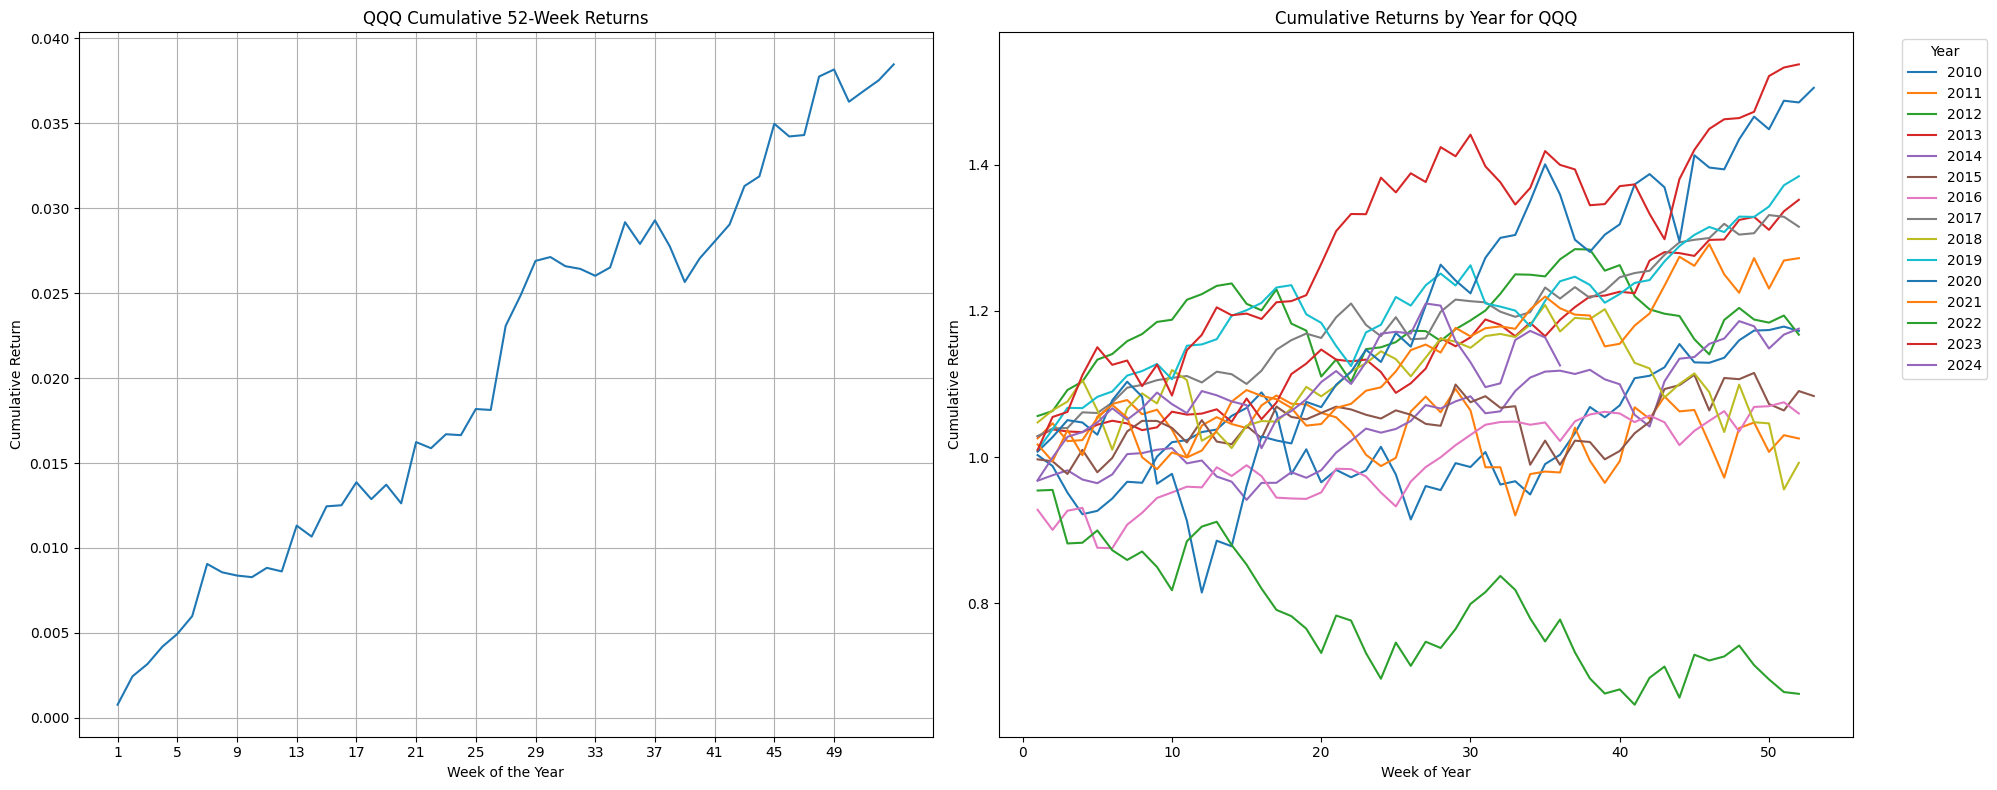

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


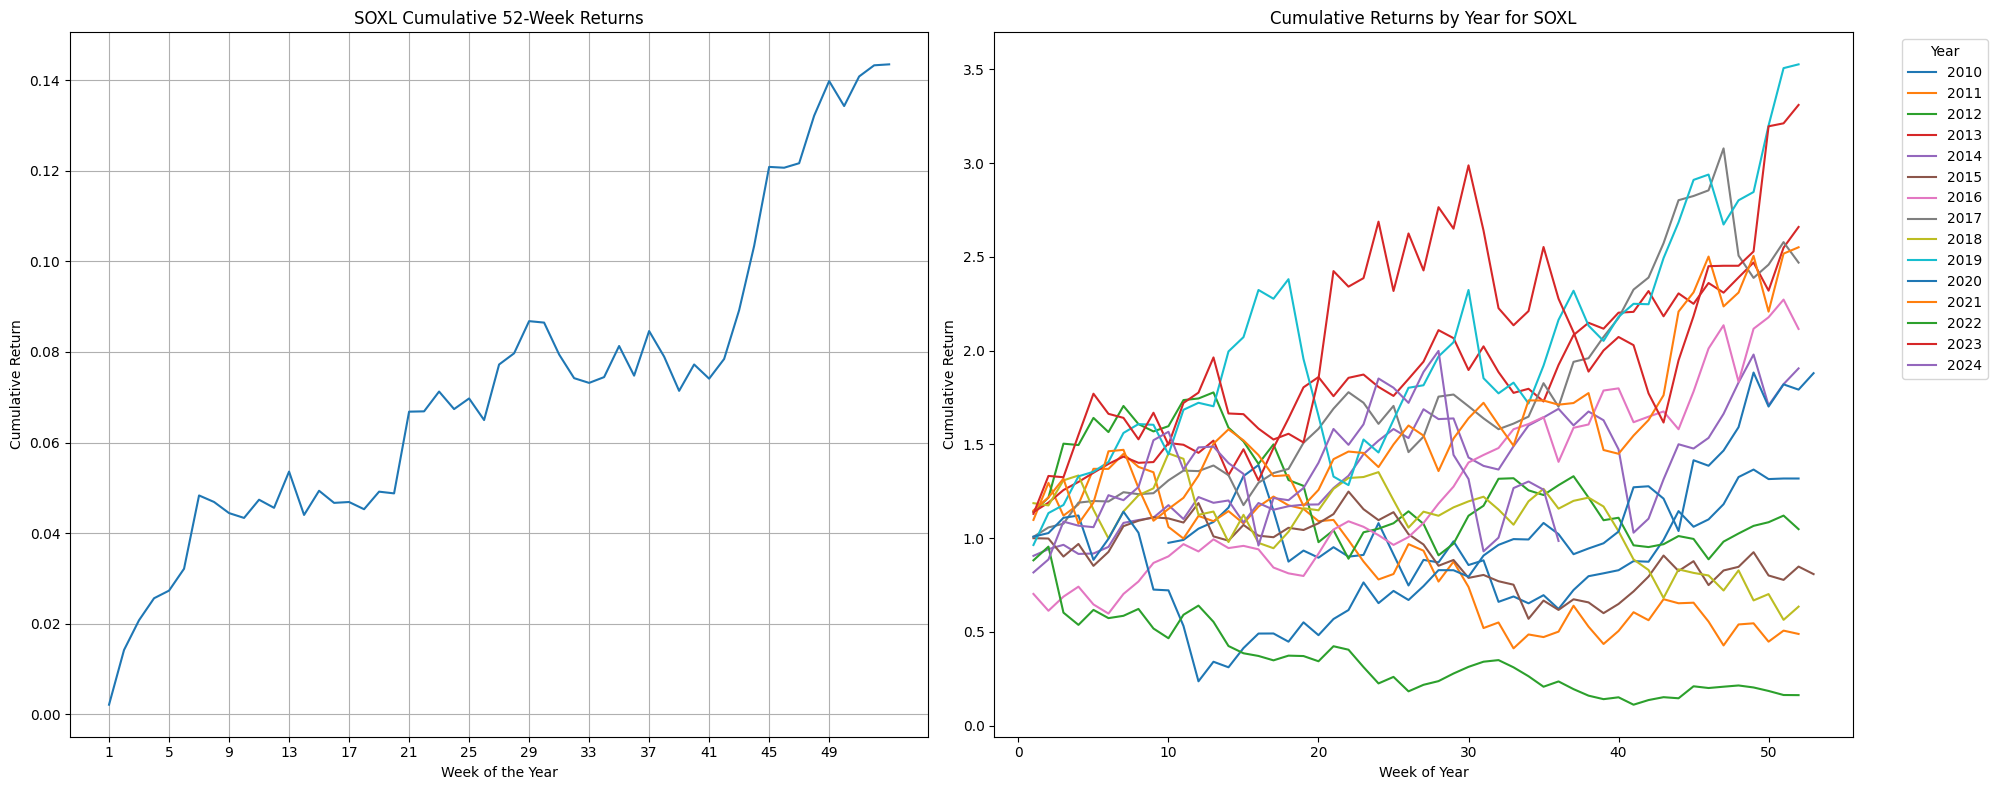

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


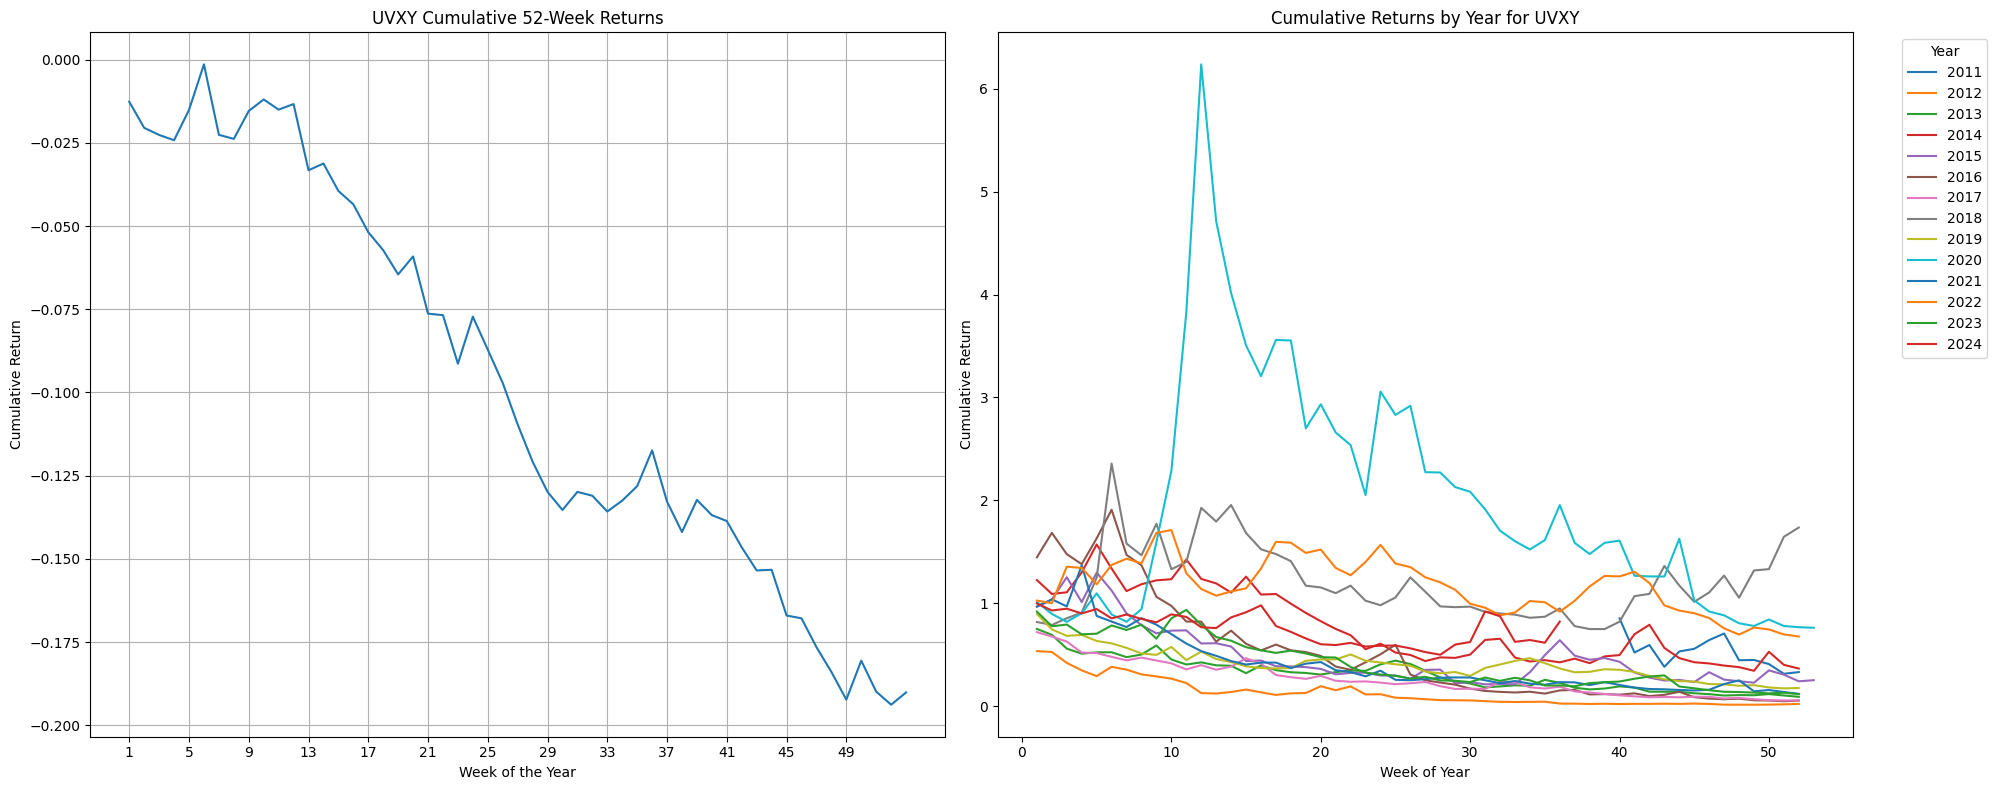

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


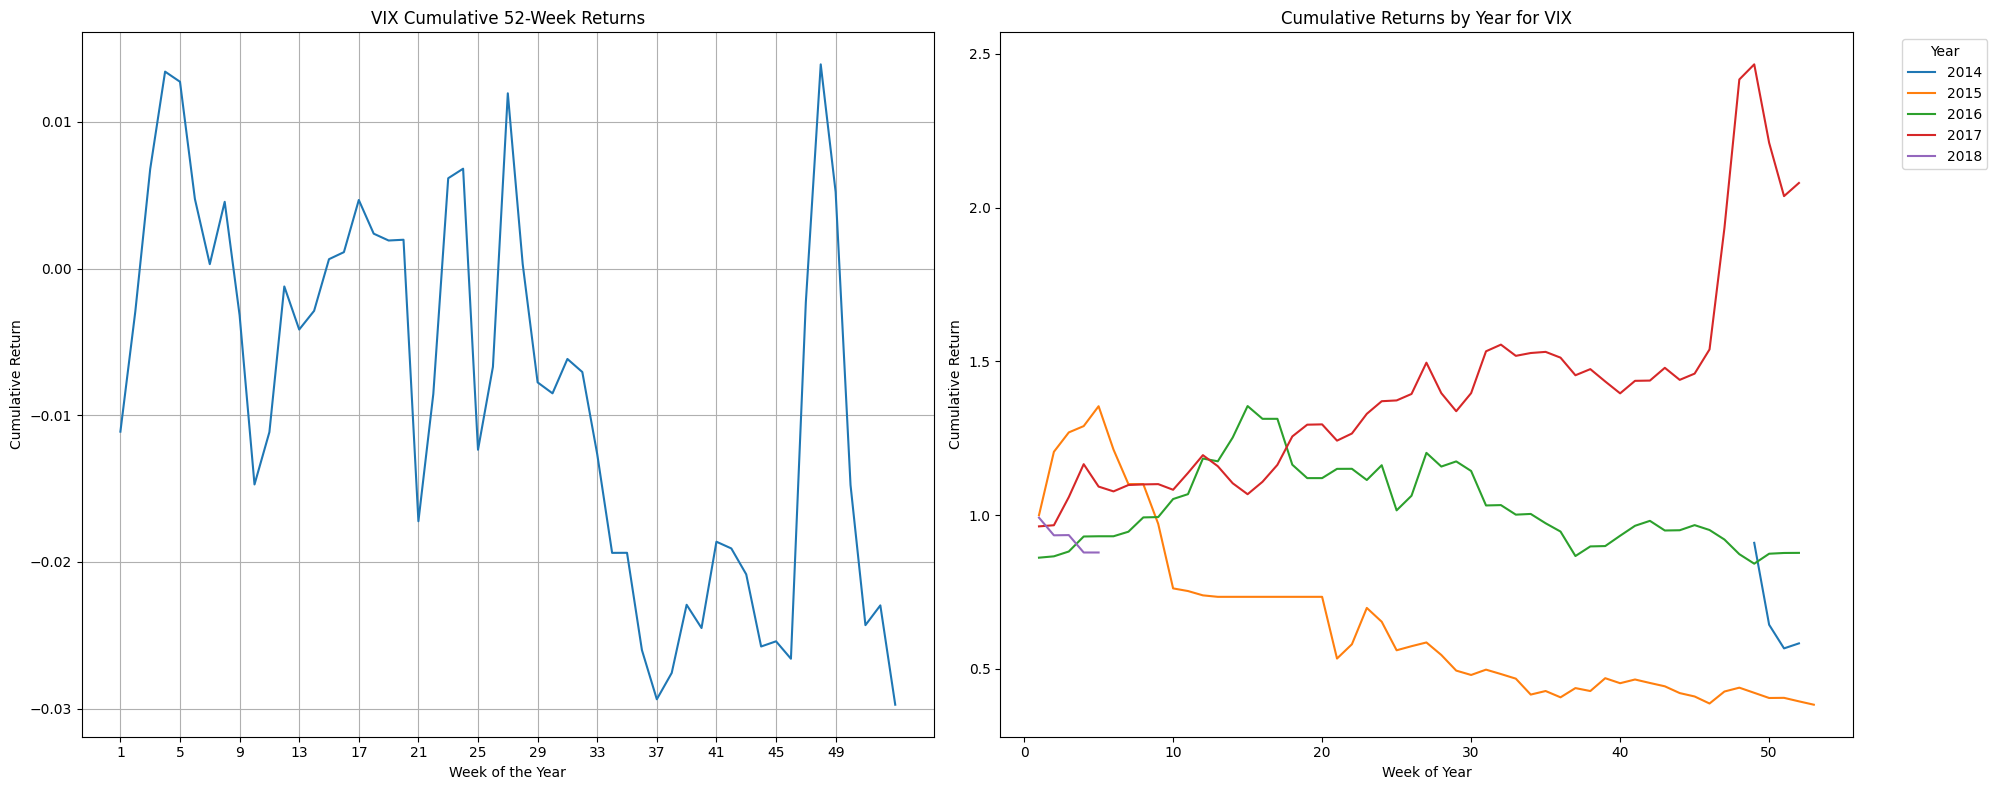

[*********************100%***********************]  5 of 5 completed


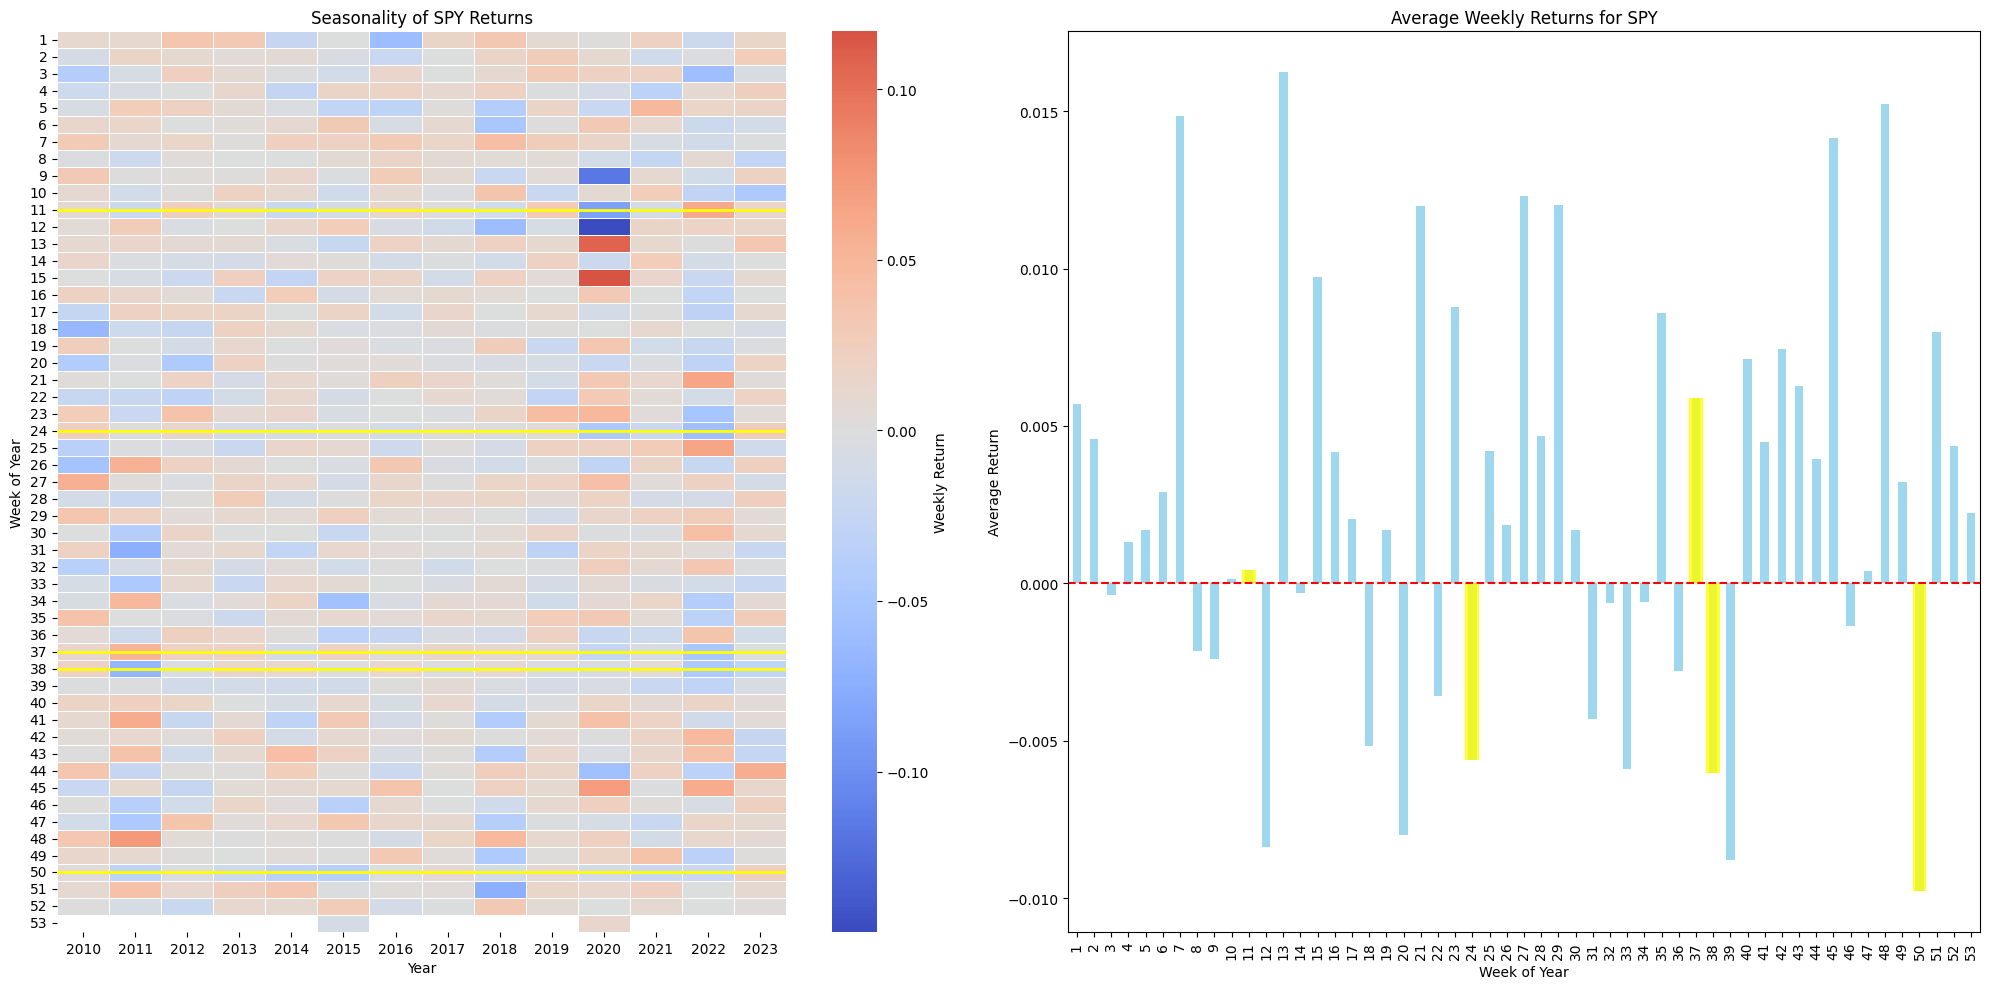

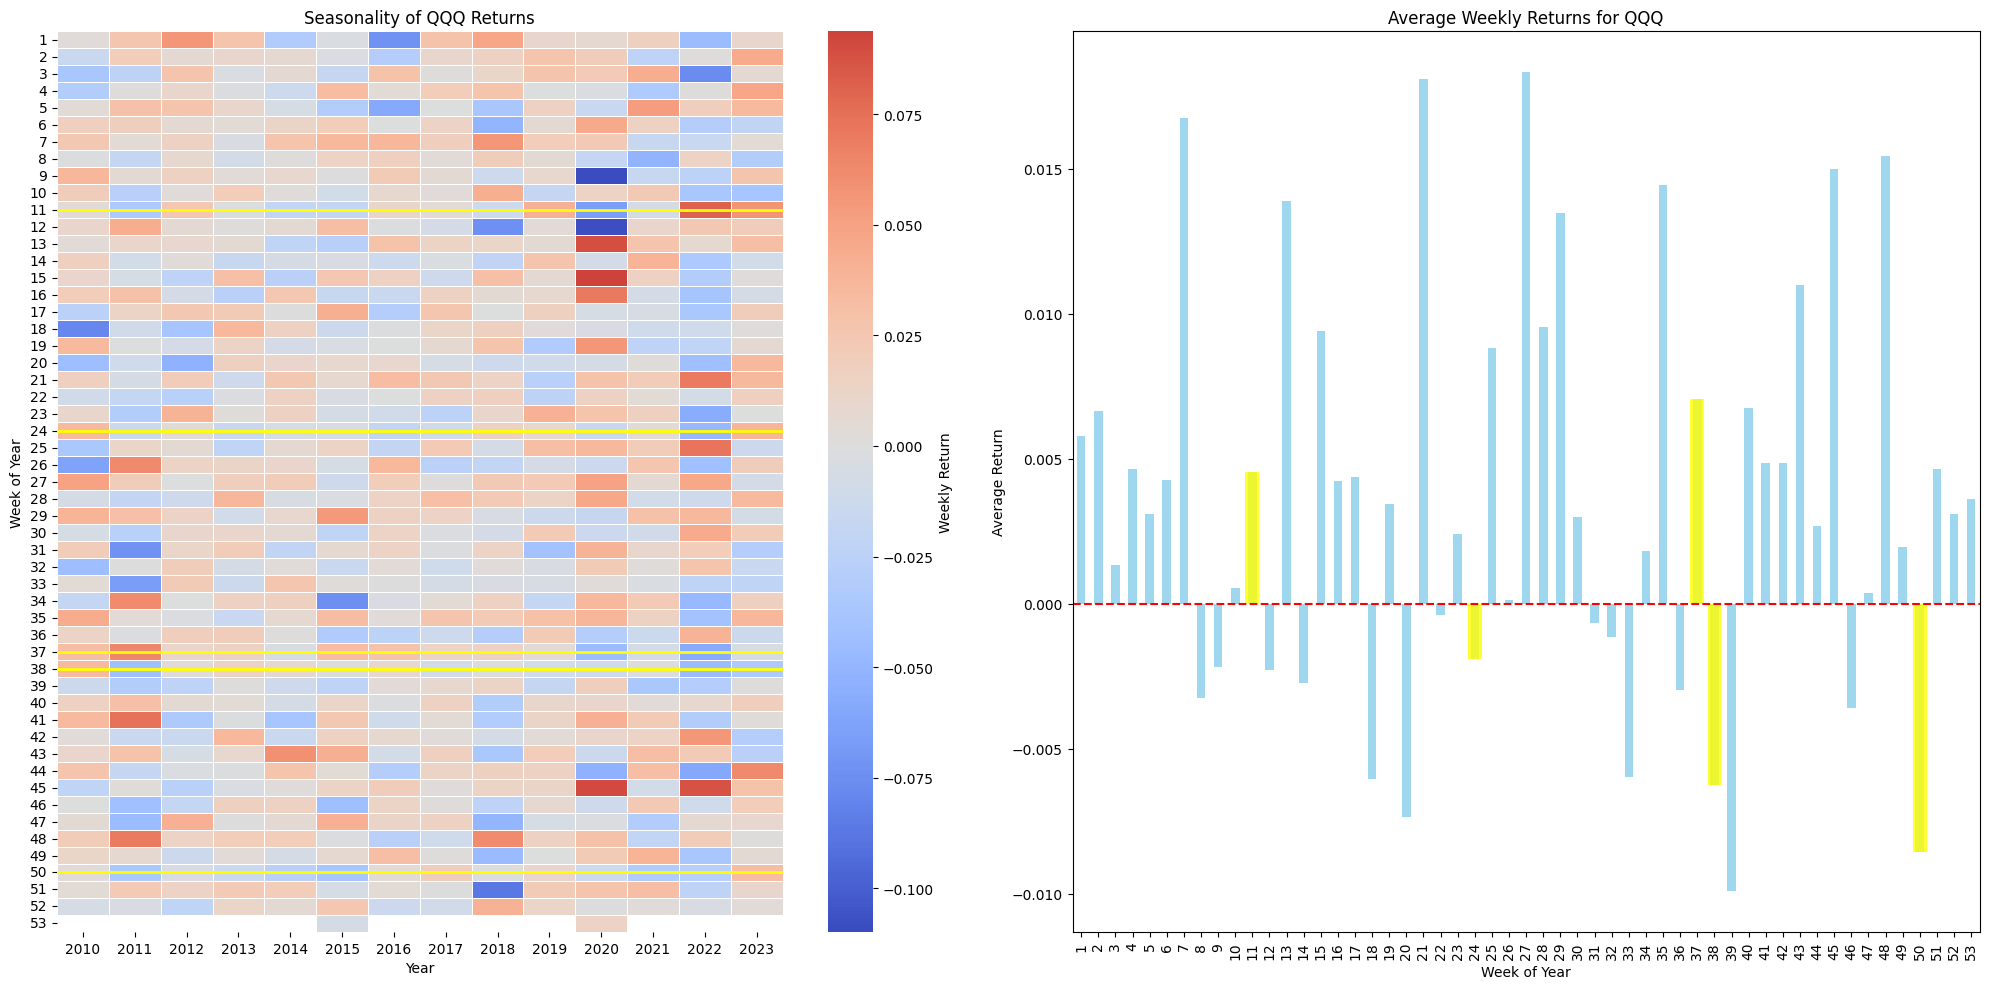

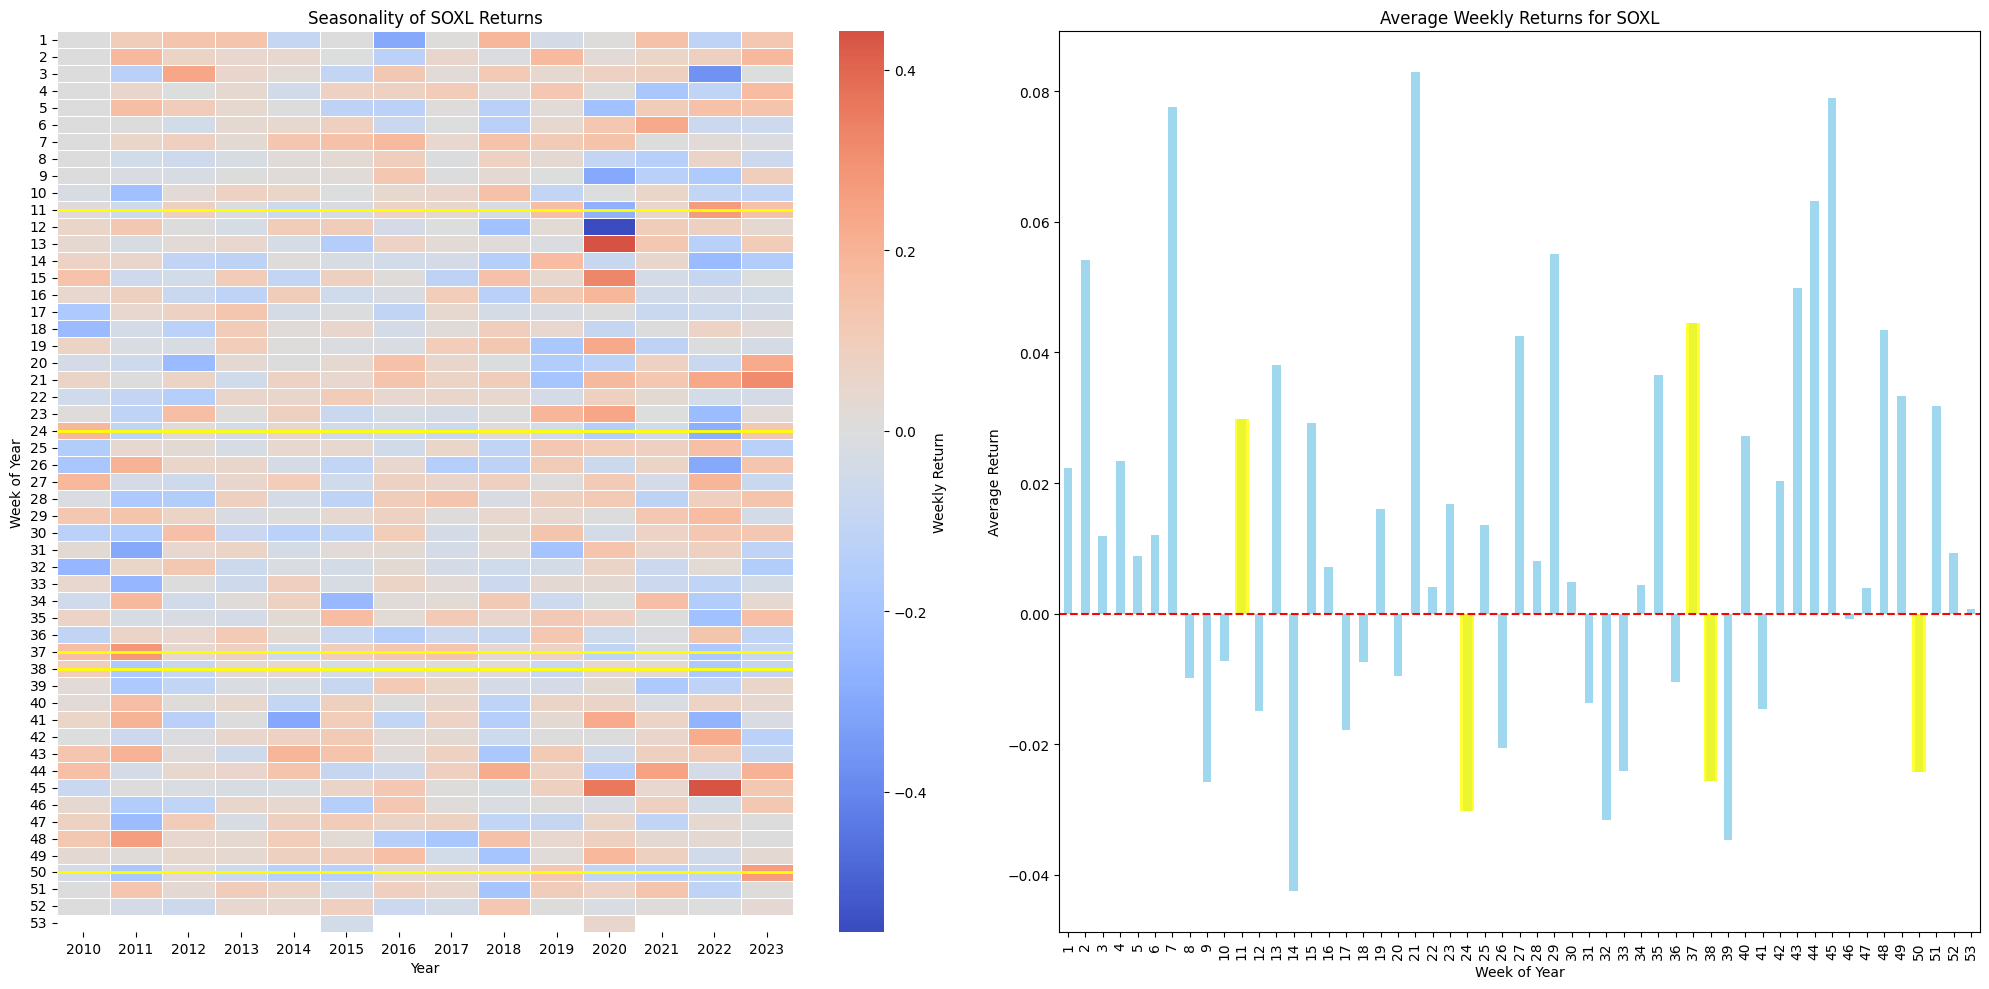

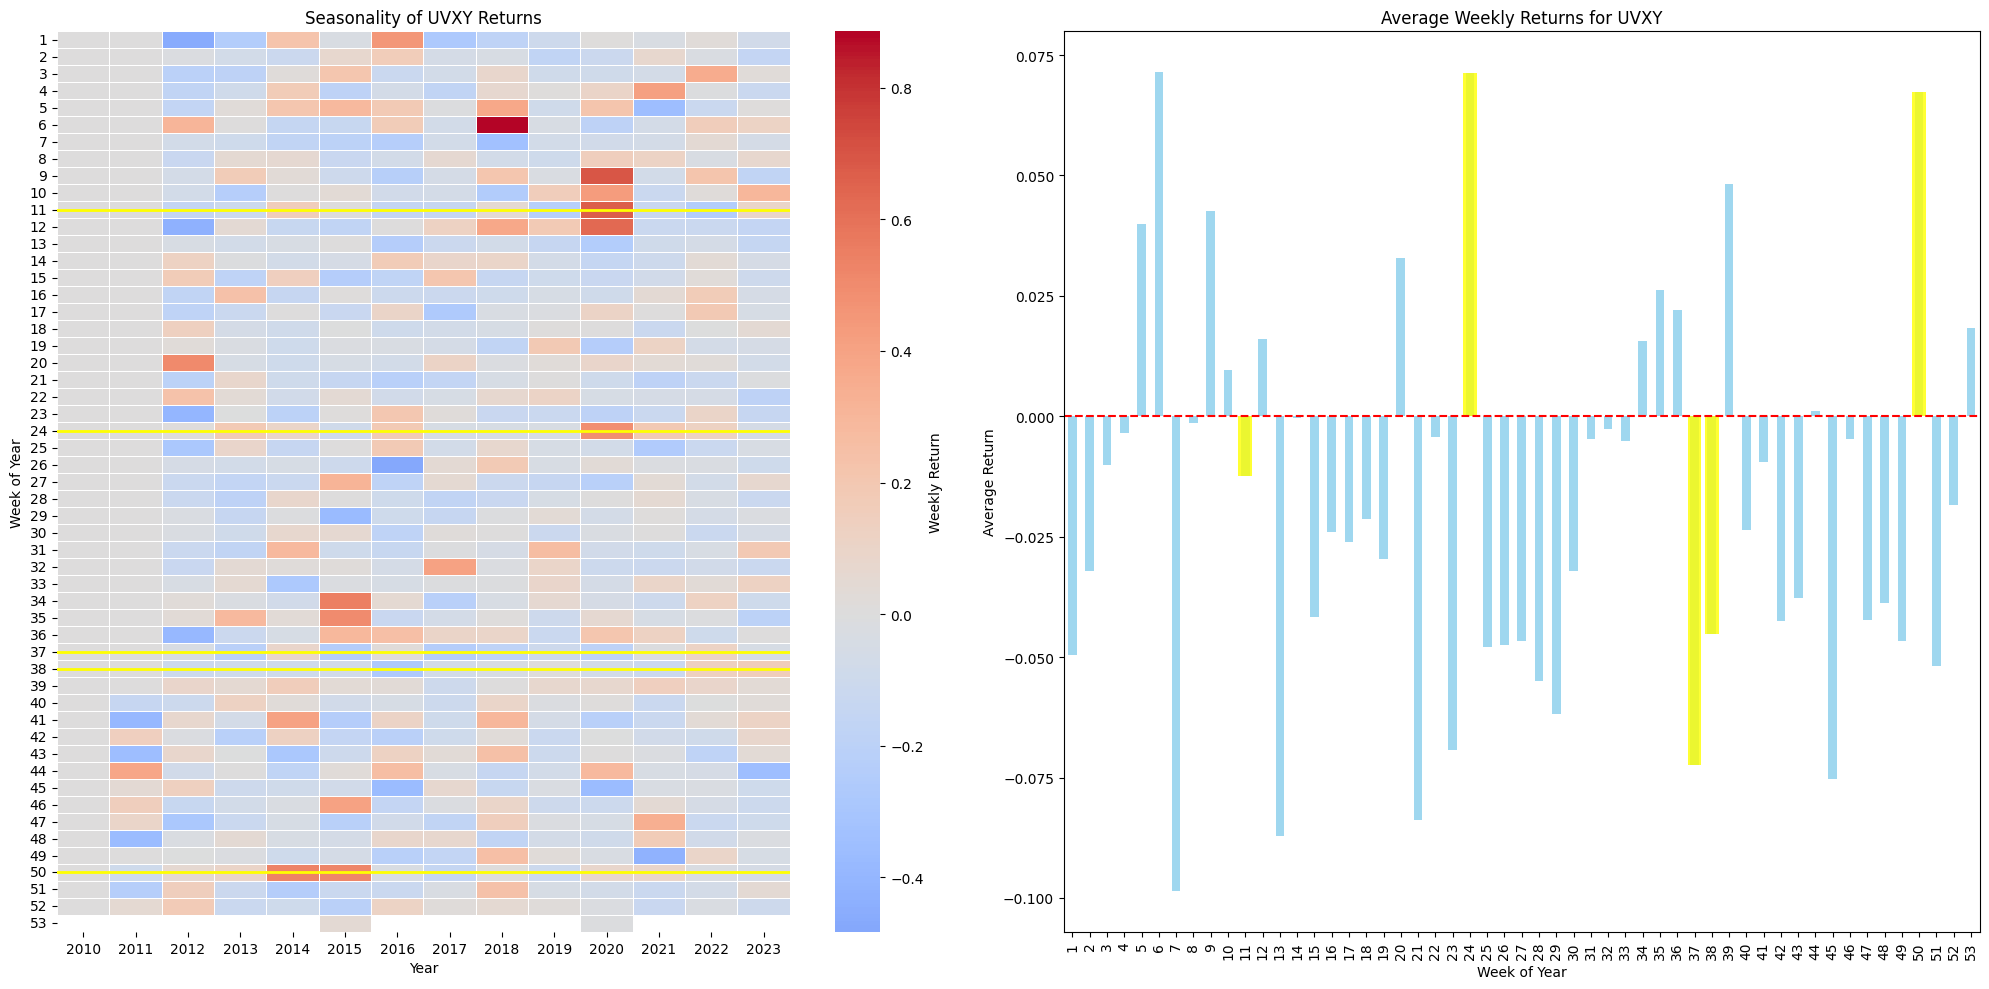

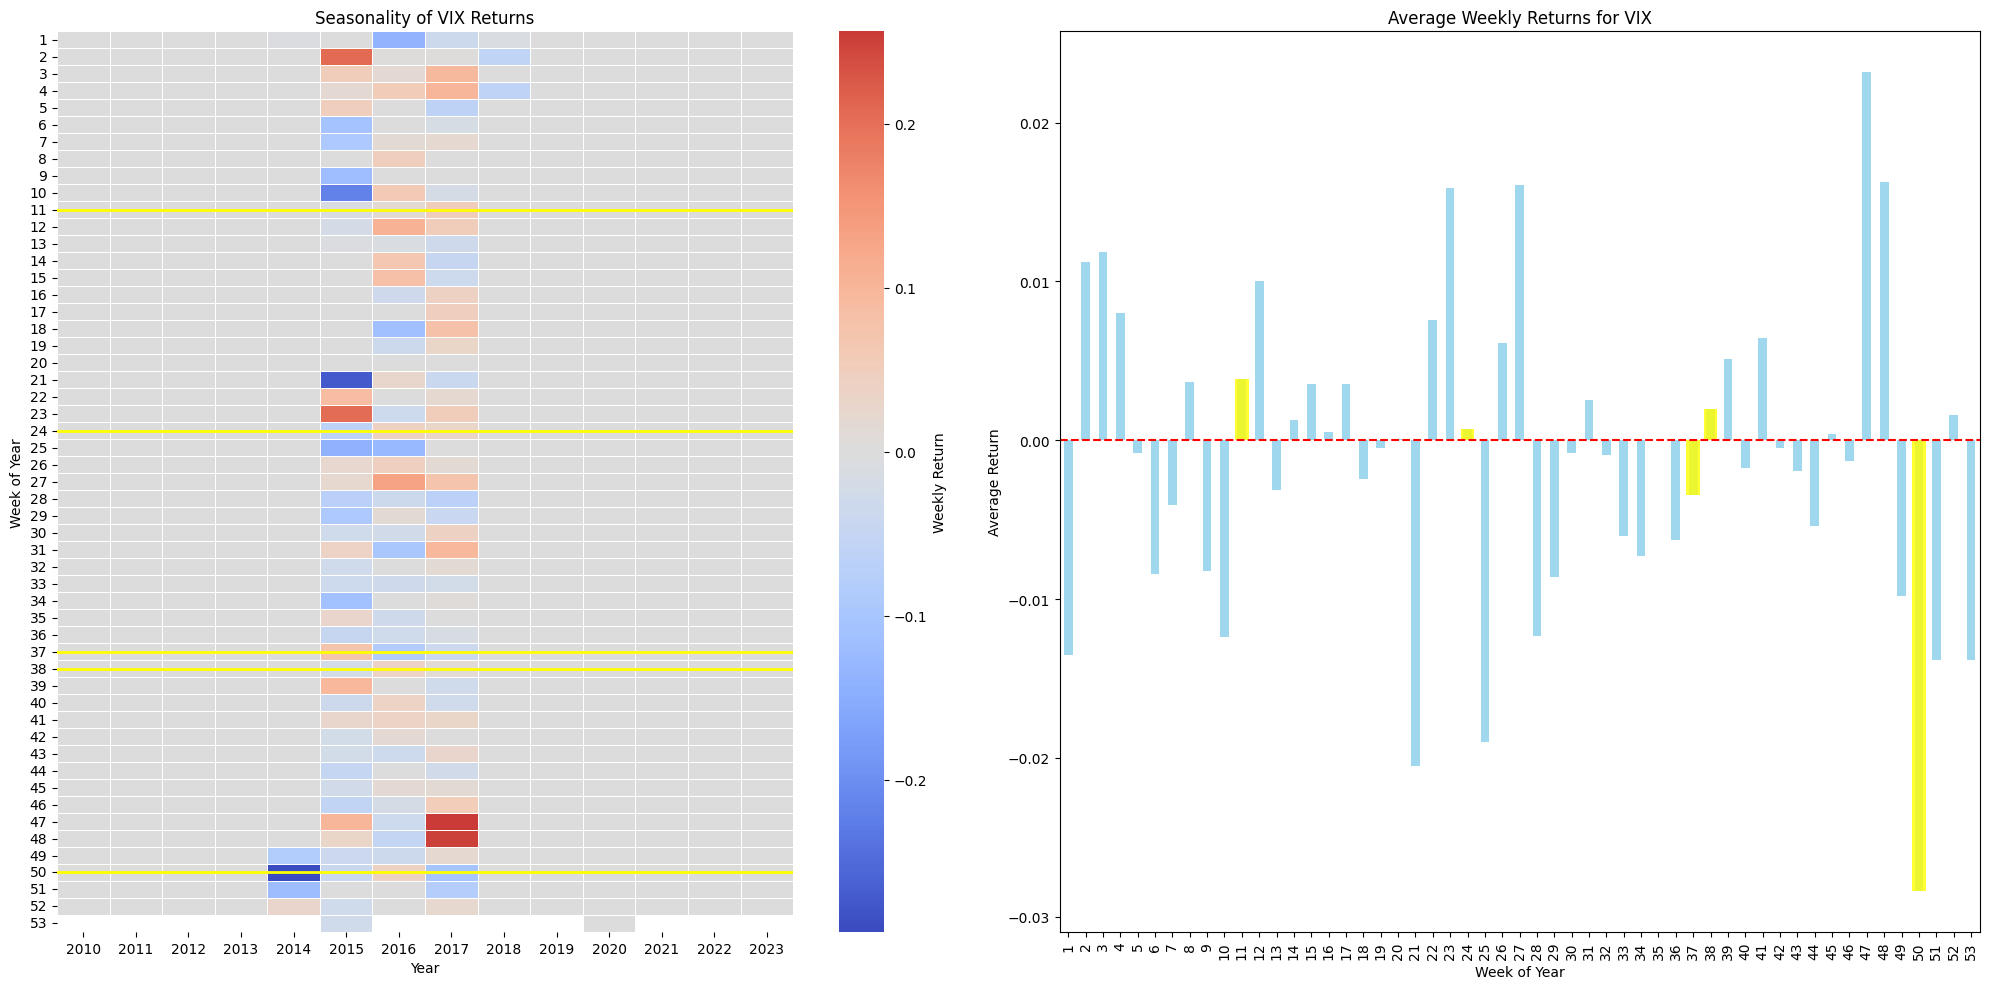

Saved SPY seasonality data to seasonality_data/SPY_seasonality.csv
Saved QQQ seasonality data to seasonality_data/QQQ_seasonality.csv
Saved SOXL seasonality data to seasonality_data/SOXL_seasonality.csv
Saved UVXY seasonality data to seasonality_data/UVXY_seasonality.csv
Saved VIX seasonality data to seasonality_data/VIX_seasonality.csv


In [ ]:
class WeeklySeasonalityVisualizer:
    def __init__(self, tickers, start_date, end_date, triple_witching_weeks, odds_ratio=2, output_dir='seasonality_data'):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.triple_witching_weeks = triple_witching_weeks
        self.odds_ratio = odds_ratio
        self.output_dir = output_dir
        self.data = None

    def fetch_data(self):
        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date, group_by='ticker')

    def visualize_weekly_seasonality(self):
        for ticker in self.tickers:
            df = self.data[ticker].copy()
            df['Return'] = df['Adj Close'].pct_change()
            df['Week_Number'] = df.index.isocalendar().week
            df['Year'] = df.index.year
            df['Ticker'] = ticker

            weekly_data = df.groupby(['Year', 'Week_Number']).agg({
                'Return': 'sum',
                'Volume': 'mean'
            }).reset_index()
            weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

            pivot_data = weekly_data.pivot(index="Week", columns="Year", values="Return")

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

            sns.heatmap(pivot_data, ax=ax1, annot=False, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, 
                        cbar_kws={'label': 'Weekly Return'})

            for week in self.triple_witching_weeks:
                ax1.axhline(y=week-0.5, color='yellow', linewidth=2)

            ax1.set_title(f'Seasonality of {ticker} Returns')
            ax1.set_ylabel('Week of Year')
            ax1.set_xlabel('Year')

            avg_weekly_returns = pivot_data.mean(axis=1)
            avg_weekly_returns.plot(ax=ax2, kind='bar', color='skyblue', alpha=0.8)
            ax2.set_title(f'Average Weekly Returns for {ticker}')
            ax2.set_xlabel('Week of Year')
            ax2.set_ylabel('Average Return')
            ax2.axhline(y=0, color='red', linestyle='--')

            for week in self.triple_witching_weeks:
                ax2.bar(week-1, avg_weekly_returns[week], color='yellow', alpha=0.8)

            plt.tight_layout()
            plt.show()

    def export_weekly_seasonality_data(self):
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        for ticker in self.tickers:
            df = self.data[ticker].copy()
            df['Return'] = df['Adj Close'].pct_change()
            df['Week_Number'] = df.index.isocalendar().week
            df['Year'] = df.index.year
            df['Ticker'] = ticker

            weekly_data = df.groupby(['Year', 'Week_Number']).agg({
                'Return': 'sum',
                'Volume': 'mean'
            }).reset_index()
            weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

            volatility = weekly_data.groupby('Week')['Return'].std().reset_index(name='Volatility')
            positive_returns = weekly_data.groupby('Week')['Return'].apply(lambda x: (x > 0).mean()).reset_index(name='Positive_Returns')

            kelly_ratio = (positive_returns['Positive_Returns'] * self.odds_ratio - 1) / self.odds_ratio
            weekly_data = weekly_data.merge(volatility, on='Week')
            weekly_data = weekly_data.merge(positive_returns, on='Week')
            weekly_data['Kelly_Ratio'] = kelly_ratio

            output_path = os.path.join(self.output_dir, f'{ticker}_seasonality.csv')
            weekly_data.to_csv(output_path, index=False)
            print(f'Saved {ticker} seasonality data to {output_path}')

class CumulativeReturnAnalyzer:
    def __init__(self, ticker, start_date='2008-01-01', end_date=None, plot=True):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')
        self.plot = plot

    def fetch_financial_data(self):
        return yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def calculate_cumulative_return(self, financial_df):
        weekly_returns = financial_df['Close'].pct_change().groupby(financial_df.index.isocalendar().week).mean()
        cumulative_returns = (1 + weekly_returns).cumprod() - 1
        return cumulative_returns

    def plot_cumulative_return(self, cumulative_returns):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        ax1.plot(cumulative_returns.index, cumulative_returns.values)
        ax1.set_title(f'{self.ticker} Cumulative 52-Week Returns')
        ax1.set_xlabel('Week of the Year')
        ax1.set_ylabel('Cumulative Return')
        ax1.set_xticks(range(1, 53, 4))
        ax1.grid(True)

        financial_df = self.fetch_financial_data()
        financial_df['Return'] = financial_df['Close'].pct_change()
        financial_df['Week_Number'] = financial_df.index.isocalendar().week
        financial_df['Year'] = financial_df.index.year

        weekly_data = financial_df.groupby(['Year', 'Week_Number'])['Return'].sum().reset_index()
        pivot_data = weekly_data.pivot(index="Week_Number", columns="Year", values="Return")
        yearly_cumulative_returns = (1 + pivot_data).cumprod()

        for year in yearly_cumulative_returns.columns:
            ax2.plot(yearly_cumulative_returns.index, yearly_cumulative_returns[year], label=year)
        
        ax2.set_title(f'Cumulative Returns by Year for {self.ticker}')
        ax2.set_xlabel('Week of Year')
        ax2.set_ylabel('Cumulative Return')
        ax2.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def process(self):
        financial_df = self.fetch_financial_data()
        cumulative_returns = self.calculate_cumulative_return(financial_df)
        if self.plot:
            self.plot_cumulative_return(cumulative_returns)
        return cumulative_returns


for ticker in tickers:
    # Fetch, calculate, and plot cumulative return for each ticker
    analyzer = CumulativeReturnAnalyzer(ticker=ticker, start_date='2010-01-01', plot=True)
    cumulative_returns = analyzer.process()    # print(cumulative_returns)


# Example usage:
triple_witching_weeks = [11, 24, 37, 38, 50]

visualizer = WeeklySeasonalityVisualizer(tickers, "2010-01-01", "2024-01-01", triple_witching_weeks)
visualizer.fetch_data()
visualizer.visualize_weekly_seasonality()
visualizer.export_weekly_seasonality_data()
